<a href="https://colab.research.google.com/github/a123700/Leo/blob/master/Reinforcement_Learning_with_a2c_structure_for_Stock_Market_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stage 1: Installing dependencies and environment setup


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Stage 2: Importing project dependencies

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from scipy.special import softmax

from tqdm import tqdm
from tqdm.contrib import tzip
from collections import deque
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
import time

## Stage 3: Building the AI Trader network

### Time Embedding

In [ ]:
# Time Embedding takes the data feature values of the time-series (ie. stock prices) as input, 
# not the 'time' values (ie. date-month-year eg. 02-04-1972).
# 
# Hence, in the Embedding formula, above, the input value, τ, corresponds to the stock price.
# The 'i' and 'k' corresponds to the size of embedding dimension.
#
# The Embedding has a dimension of two (ie. k == 2 in the formula): 
#    The first dimension (ie. i == 0) is the 'non-periodic' or 'linear' feature ie. ωᵢτ + φᵢ
#    The second dimension (ie. i == 1) is the 'periodic' feature ie. F(ωᵢτ + φᵢ)
#    NB: We could have additional dimensions ie. third, fourth etc by adding more periodic features
#        with different weights
#
# The linear feature (ie. t2v(τ) = ωᵢτ + φᵢ) is just a straight line formula (ie. y = mᵢx + bᵢ), 
#    where ω is the slope and φ is the y-intercept, as shown in the gra
# For the periodic feature, the linear function (ωᵢτ + φᵢ) is wrapped in an additional function F(). 
#    This F() can be any function (eg. sin, cos, relu...). Here we use sine, where φ shifts the sine 
#    function along the x-axis and ω determines the wavelength of the sine function, as shown in the
#    graph above.
#
#
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    # initiate 4 matrices, 2 for ω and 2 forφ since we need aω and φ matrix for 
    # both non-periodical (linear) and the periodical (sin) features.
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  # 'x' shape is (batch_size, seq_len, 5) → (32, 128, 5). The batch_size defines how 
  # many stock price sequences we want to feed into the model/layer at once. The seq_len 
  # parameter determines the length of a single stock price sequence. Lastly, the 
  # number 5 is derived from the fact that we have 5 features of the daily IBM stock 
  # recording (Open price, High price, Low price, Close price, Volume)
  def call(self, x):
    '''Calculate linear and periodic time features'''

    # Exclude Volume and average across the Open, High, Low, and Close prices, resulting 
    # in the shape (batch_size, seq_len)
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)

    # calculate the non-periodic (linear) time feature and expand the dimension by 1 again ie. (batch_size, seq_len, 1)
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    # repeat for the periodic time feature, also resulting in the same matrix shape. (batch_size, seq_len, 1)
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)

    # concatenate the linear and periodic time feature. (batch_size, seq_len, 2)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

### Custom learning rate

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### Transformer encoder

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

### Trader Structure

In [ ]:
class AI_Trader():
  def __init__(self, state_size, maxlen, action_space=3, model_name="AITrader", d_rate = 0.95): #Stay, Buy, Sell
    
    self.state_size = state_size
    self.action_space = action_space
    self.memory = deque(maxlen=maxlen)
    self.action_reward = []
    self.long_inventory = []
    self.short_inventory = []
    self.net_capital = []
    self.model_name = model_name
    
    # Define hyperparamaters
    self.gamma = d_rate
    self.epsilon = 1.0
    self.epsilon_final = 0.01
    self.epsilon_decay = 0.95
        
    # Call a function  to build a model trought this class constructor
    # More parameters could be ustilized to programaticaly define network size (layers and neurons)
    self.model = self.model_builder(    
    input_shape=(state_size, 1),
    head_size=256,
    num_heads=10,
    ff_dim=5,
    num_transformer_blocks=20,
    mlp_units=[512, 256, 128, 64, 32, 16, 8],
    mlp_dropout=0,
    dropout=0)

  def reset(self):
    self.long_inventory = []
    self.short_inventory = []
    self.net_capital = []
    self.action_reward = []

  def model_builder(self, 
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    input_shape,
    dropout=0,
    mlp_dropout=0):
    input1 = keras.Input(shape=input_shape)
    x = input1
    time_embedding = Time2Vector(window_size)
    x = time_embedding(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    x = layers.Dense(16, activation="relu")(x)

    input2 = layers.Input(shape=(1))
    input3 = layers.Input(shape=(1))
    input4 = layers.Input(shape=(1))

    x = layers.Concatenate()([x, input2, input3, input4])
    actor = layers.Dense(units = 32, activation='relu')(x)
    actor = layers.Dense(units = 16, activation='relu')(actor)
    actor = layers.Dense(units = 8, activation='relu')(actor)
    output1 = layers.Dense(units=self.action_space, activation='softmax')(actor)

    critic = layers.Dense(units = 32, activation='relu')(x)
    critic = layers.Dense(units = 16, activation='relu')(critic)
    critic = layers.Dense(units = 8, activation='relu')(critic)
    output2 = layers.Dense(units=1, activation='linear')(critic)

    model = Model(inputs = [input1, input2, input3, input4], outputs = [output1, output2], name = self.model_name)
    model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=optimizer)
    return model

  def performace_calculate(self, data, y, window_size, episodes, budget, data_samples, batch_size, trade_training_process):
    for episode in range(1, episodes + 1):
      start = time.time()
      long_time = []
      short_time = []
      print("Episode: {}/{}".format(episode, episodes))
      
      # Create state
      state = state_creator(data, window_size, window_size + 1).reshape(1, -1)
      
      total_profit = 0
      # Reset before starting episode
      trader.reset()
      holding_times = 0

      # tqdm is used for visualization
      for t in range(window_size, data_samples):
        emotion = np.array(0).reshape(-1, 1)
        long_position = np.array(len(self.long_inventory)).reshape(-1, 1)
        short_position = np.array(len(self.short_inventory)).reshape(-1, 1)
        action, expectation = trader.trade(state, emotion, long_position, short_position)

        reward = 0

        if len(self.long_inventory) > 0:
          emotion = np.array(sum(-np.array(self.long_inventory) + y[t])).reshape(-1, 1)
        
        if len(self.short_inventory) > 0:
          emotion = np.array(sum(np.array(self.short_inventory) - y[t])).reshape(-1, 1)

        
        if action == 0 and len(self.long_inventory) < budget and len(self.short_inventory) == 0: 
          self.long_inventory.append(y[t])
          reward = 10
          holding_times = 0
          long_time.append(t)
          # print("\nAt {}/{}, AI Trader bought: ".format(t+1, data_samples), stocks_price_format(y[t]), ', Long Position Inventory: ', len(trader.long_inventory), ', Unrealized profit $', int(emotion))
          
        elif action == 0 and len(self.long_inventory) == 0 and len(self.short_inventory) > 0: 
          sell_price = self.short_inventory.pop(0)
          long_time.append(t)

          p = sell_price - y[t]
          reward = p - expectation
          holding_times = 0
          total_profit += p
          # print("\nAt {}/{}, AI Trader closed position: ".format(t+1, data_samples), stocks_price_format(y[t]), " Profit: " + stocks_price_format(p), " Current Profit: " + stocks_price_format(total_profit), ', Unrealized profit $', int(emotion))

        elif action == 1 and len(self.long_inventory) > 0: 
          buy_price = self.long_inventory.pop(0)
          holding_times = 0
          short_time.append(t)
          p = y[t] - buy_price 
          reward = p - expectation
          total_profit += p
          # print("\nAt {}/{}, AI Trader sold: ".format(t+1, data_samples), stocks_price_format(y[t]), " Profit: " + stocks_price_format(p), " Current Profit: " + stocks_price_format(total_profit), ', Unrealized profit $' , int(emotion))
        
        elif action == 1 and len(self.short_inventory) < budget and len(self.long_inventory) == 0: 
          self.short_inventory.append(y[t])
          holding_times = 0
          reward = 2
          short_time.append(t)
          # print("\nAt {}/{}, AI Trader shorted: ".format(t+1, data_samples), stocks_price_format(y[t]), ', Short Position Inventory: ', len(trader.short_inventory), ', Unrealized profit $', int(emotion))

        else:
          # print("\nAt {}/{}, AI Trader held. ".format(t+1, data_samples), " Current Profit: " + stocks_price_format(total_profit), ', Unrealized profit $', int(emotion))
          holding_times += 1
          reward = -1000
          

        if t == data_samples - 1:
          done = True
          final_p = 0
          if len(self.long_inventory) > 0:
            for i in self.long_inventory:
              final_p += y[t] - i
          elif len(self.short_inventory) > 0:
            for i in self.short_inventory:
              final_p += i - y[t]
          total_profit += final_p
          print("\nClosed Profit {} ".format(stocks_price_format(final_p)), " Current Profit: " + stocks_price_format(float(total_profit)))
          reward += final_p
        else:
          done = False
          
        # Use action to get to next state(t+)
        self.net_capital.append(total_profit)
        next_state = state_creator(data, t+1, window_size + 1).reshape(1, -1)

        # Append all data to trader-agent memory, experience buffer
        self.memory.append((state, action, next_state, emotion, long_position, short_position, done))
        self.action_reward.append(reward)
        
        # change state to next state, so we are done with an episode
        state = next_state
        
        if done:
          print("########################")
          print("TOTAL PROFIT: {}. Time taken for 1 episode: {} secs".format(stocks_price_format(float(total_profit)), round(time.time() - start, 2)))
          print("########################")
          trade_training_process.append(total_profit)
          plt.figure(figsize=(12, 6))
          plt.plot(self.net_capital)
          plt.title('Net Capital')
          plt.ylabel('Capital')
          plt.xlabel('Epochs')
          plt.show()

          plt.figure(figsize=(12, 6))
          plt.plot(y.values, color = 'blue', label = stock_name, lw=2.)  
          plt.plot(y.values, '^', markersize=5, color='red', label = 'buying signal', markevery = long_time)
          plt.plot(y.values, 'v', markersize=5, color='green', label = 'selling signal', markevery = short_time)
          plt.xlabel('Time')
          plt.legend()
          plt.show()

        # Check if we have more information in our memory than batch size
        if len(self.memory) >= batch_size:
          trader.batch_train()
 

  # Trade function that takes state as an input and returns an action 
  # to perform in perticular state 
  def trade(self, state, emotion, long_position, short_position):
    actions, expectation = self.model.predict([state, emotion, long_position, short_position], verbose = 0)
    if random.random() <= self.epsilon:
      return random.randrange(self.action_space), expectation
    
    actions = np.random.choice(np.arange(self.action_space), size = 1, replace = False, p = actions[0])
    return actions, expectation

  def batch_train(self):
    loss_obj_reg = tf.keras.losses.MeanAbsoluteError()
    loss_obj_cat = tf.keras.losses.CategoricalCrossentropy()
    discounted_reward = trader.discounted_reward(self.action_reward)
    for i, reward in tzip(self.memory, discounted_reward):
      state, action, next_state, emotion, long_position, short_position, done = i[0], i[1], i[2], i[3], i[4], i[5], i[6]
      total_reward = reward
      target = np.ones((1, self.action_space))
      _, expectation = self.model.predict([state, emotion, long_position, short_position], verbose=0)
      _, expectation1 = self.model.predict([next_state, emotion, long_position, short_position], verbose=0)
      advantage = total_reward - (expectation - expectation1)
      target[0][action] = advantage
      target = softmax(target, axis = 1)
      
      with tf.GradientTape() as tape:
        pred_cat, pred_reg = self.model([state, emotion, long_position, short_position], training=True)
        cat_loss = loss_obj_cat(target, pred_cat)
        reg_loss = loss_obj_reg(total_reward, pred_reg)
      gradients = tape.gradient([cat_loss, reg_loss], self.model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    self.memory = []
    # We will decrease epsilon parameter that is 1 as defined in __init__  so
    #    so we can stop performing random actions at some point
    if self.epsilon > self.epsilon_final:
      self.epsilon *= self.epsilon_decay

  def discounted_reward(self, reward):
    result = []
    for i in range(len(reward)):
      temp = np.array(reward[i:])
      temp1 = np.logspace(0, len(temp), len(temp), base = self.gamma)
      result.append(np.squeeze(temp).dot(np.squeeze(temp1)))
    return result 

## Stage 4: Dataset preprocessing

### Defining helper functions

#### Price format function

In [ ]:
def stocks_price_format(n):
  if n < 0:
    return "- $ {:.1f}".format(abs(n))
  else:
    return "$ {:.1f}".format(abs(n))

#### Dataset loader

In [ ]:
!pip install -q yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 50 kB 4.9 MB/s 
     |████████████████████████████████| 128 kB 9.5 MB/s 
     |████████████████████████████████| 4.0 MB 83.9 MB/s 
     |████████████████████████████████| 110 kB 89.5 MB/s 
     |████████████████████████████████| 62 kB 46.4 MB/s 
     |████████████████████████████████| 112 kB 90.7 MB/s 


In [ ]:
import yfinance as yf 

def dataset_loader(stock_name, start_time, end_time = None):
  if end_time == None:
    dataset = yf.download(stock_name, start=start_time)[1:]
    dataset = np.log(dataset['Close']/dataset['Close'].shift(1))
    return dataset.dropna()

  else:
    dataset = yf.download(stock_name, start=start_time, end = end_time)[1:]
    dataset = np.log(dataset['Close']/dataset['Close'].shift(1))
    return dataset.dropna()

def high_frequency_dataset_loader(stock_name, period, interval):
  dataset = yf.download(stock_name, period=period, interval=interval)[1:]
  dataset1 = np.log(dataset['Close']/dataset['Close'].shift(1))
  
  return dataset['Open'], dataset1.dropna()

### Loading a training dataset

In [ ]:
stock_name = "^TWII"
start_time = '2007-01-01'
end_time = '2008-12-31'

data = dataset_loader(stock_name, start_time = start_time, end_time = end_time)
# y, data = high_frequency_dataset_loader(stock_name, period = '4d', interval = '1m')
y = yf.download(stock_name, start=start_time, end = end_time)['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


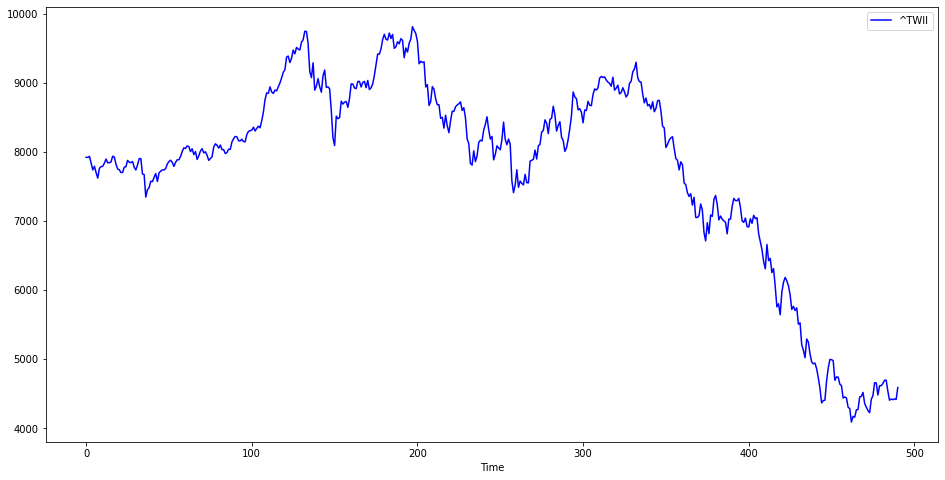

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y.values, color = 'blue', label = stock_name)  
plt.xlabel('Time')
plt.legend()
plt.show()

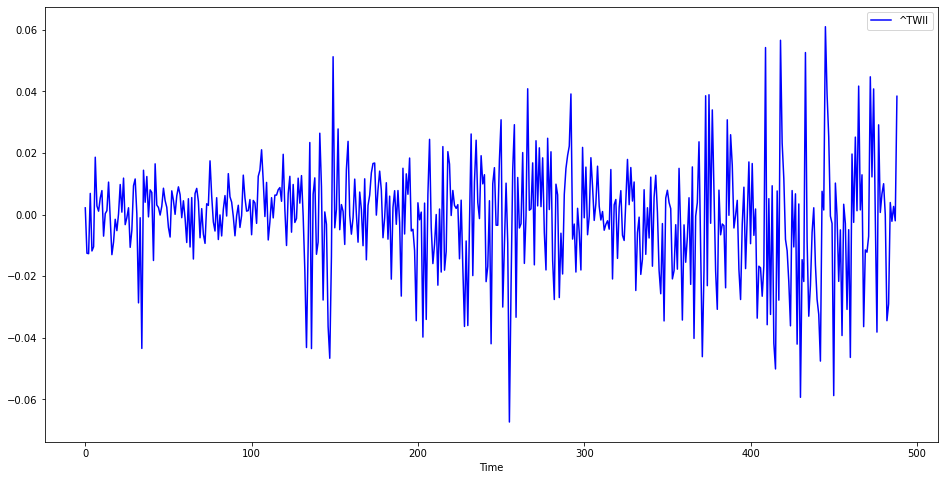

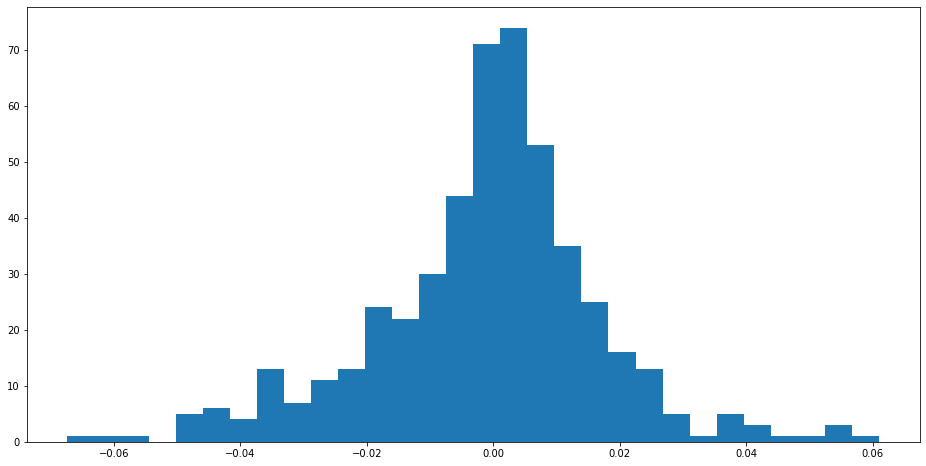

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(data.values, color = 'blue', label = stock_name)  
plt.xlabel('Time')
plt.legend()
plt.show()

plt.figure(figsize=(16, 8))
plt.hist(data, bins = 30)
plt.show()

### State creator

In [ ]:
# Data -> dataset to predict from, gathered by data:loader()
# Timestep -> Day in the dataset that we want to predict for [0:datalength]
# window_size -> how many days in past we want to use to predict current status[1:datalength]
#         Try different setup to see what creates best fit
def state_creator(data, timestep, window_size):
  starting_id = timestep - window_size + 1
  
  if starting_id >= 0:
    windowed_data = data[starting_id:timestep+1]
  else:
    windowed_data = - starting_id * [data[0]] + list(data[0:timestep+1])
    
  state = []
  for i in range(window_size - 1):
    d = windowed_data[i]
    state.append(d)

  return np.array(state).reshape(-1, 1)

## Stage 5: Training the AI Trader

### Setting hyperparameters

In [ ]:
window_size = 20
episodes = 75 # same as epoch
budget = len(data)

data_samples = len(data) # discard last value, that we will predict on
batch_size = (len(data) - window_size)

In [ ]:
learning_rate = CustomSchedule(window_size)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9, clipvalue=1)

In [ ]:
state_creator(data, window_size, window_size + 1).reshape(1, -1)

array([[ 0.00217136, -0.01254797, -0.01269707,  0.00686559, -0.01181401,
        -0.01044207,  0.01861663,  0.00280344,  0.00110173,  0.00536284,
         0.00778179, -0.00700342,  0.00030481,  0.00126024,  0.0105373 ,
        -0.0014843 , -0.01301379, -0.00892953, -0.00153371, -0.00521649]])

### Defining the Trader model

In [ ]:
trader = AI_Trader(window_size, batch_size)

In [ ]:
# trader.model.summary()

In [ ]:
# plt.figure(figsize=(8, 4))
# tf.keras.utils.plot_model(trader.model, show_shapes=True)

### Training loop

Episode: 1/75

Closed Profit $ 0.0   Current Profit: - $ 23469.5
########################
TOTAL PROFIT: - $ 23469.5. Time taken for 1 episode: 47.88 secs
########################


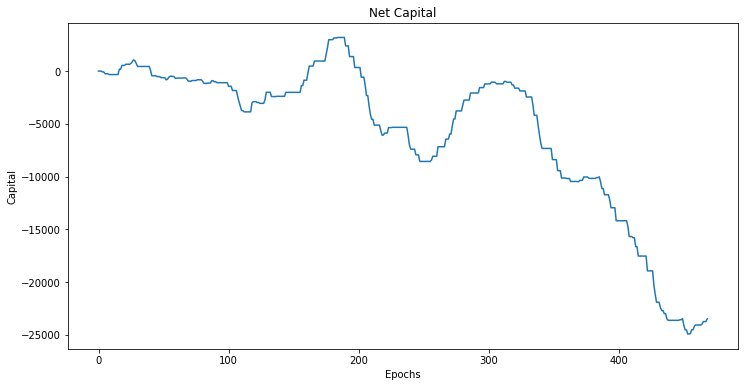

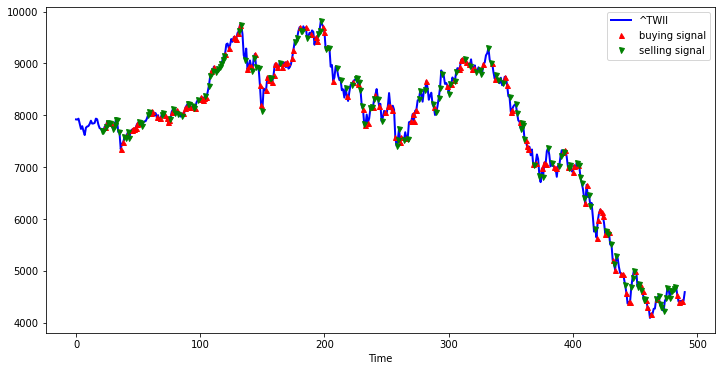

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 2/75

Closed Profit $ 1091.6   Current Profit: $ 45632.6
########################
TOTAL PROFIT: $ 45632.6. Time taken for 1 episode: 42.7 secs
########################


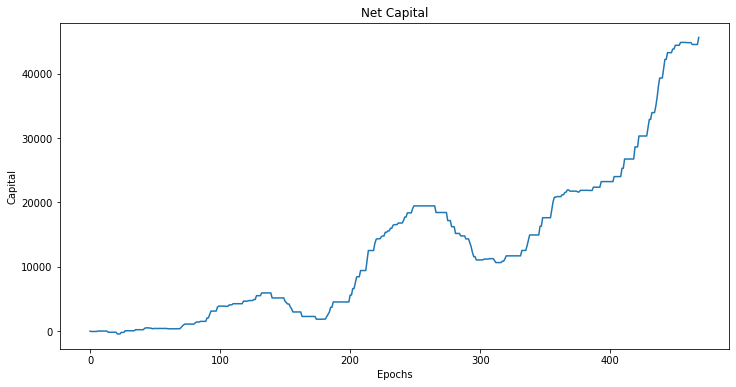

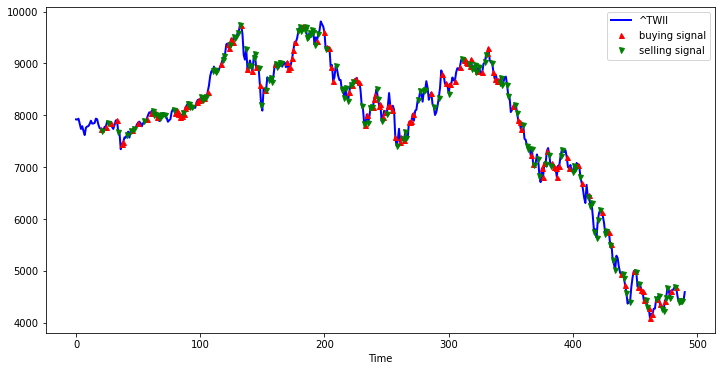

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 3/75

Closed Profit - $ 2140.7   Current Profit: - $ 39339.2
########################
TOTAL PROFIT: - $ 39339.2. Time taken for 1 episode: 42.55 secs
########################


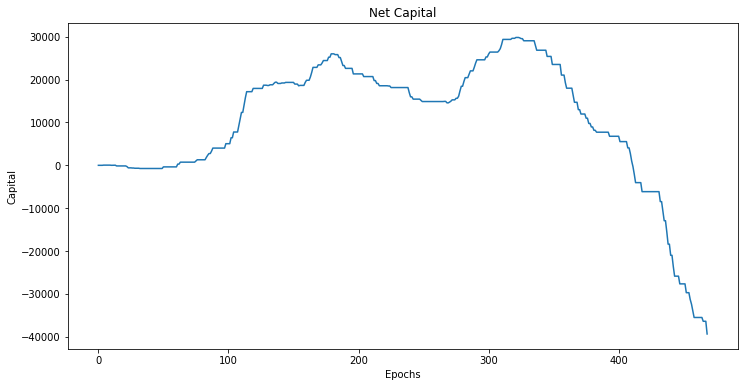

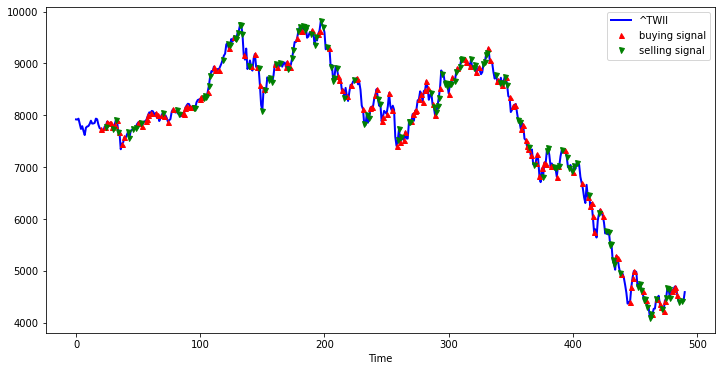

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 4/75

Closed Profit - $ 44468.4   Current Profit: - $ 112622.3
########################
TOTAL PROFIT: - $ 112622.3. Time taken for 1 episode: 41.72 secs
########################


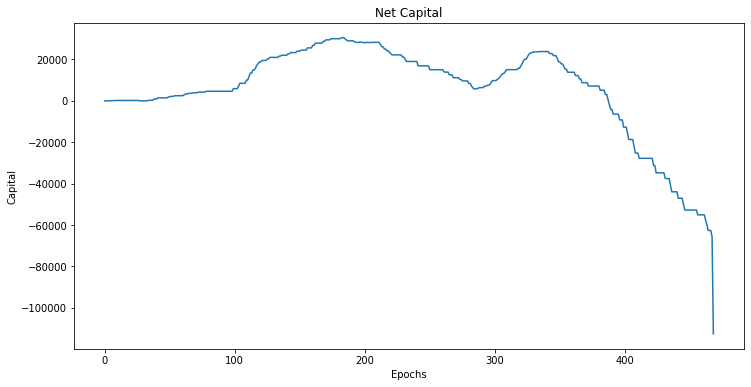

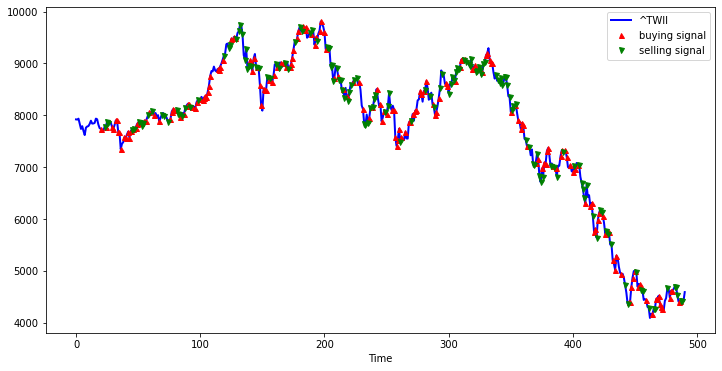

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 5/75

Closed Profit $ 47.7   Current Profit: $ 93339.6
########################
TOTAL PROFIT: $ 93339.6. Time taken for 1 episode: 41.48 secs
########################


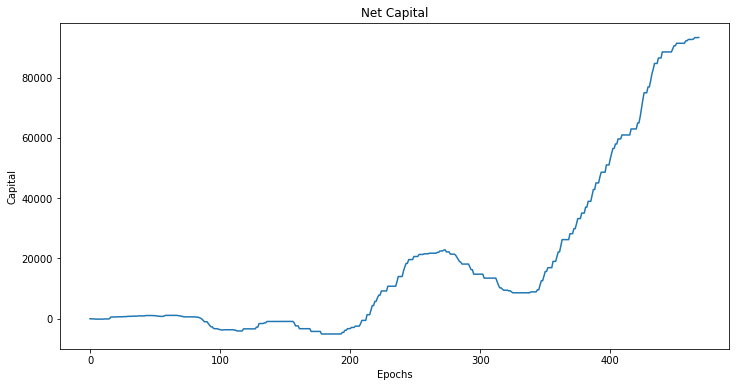

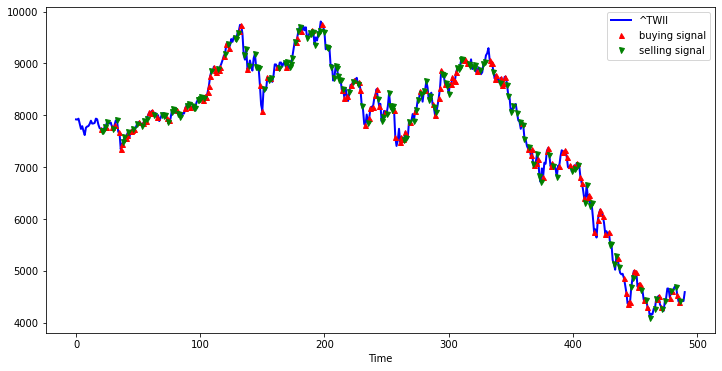

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 6/75

Closed Profit - $ 567.1   Current Profit: $ 59269.2
########################
TOTAL PROFIT: $ 59269.2. Time taken for 1 episode: 41.73 secs
########################


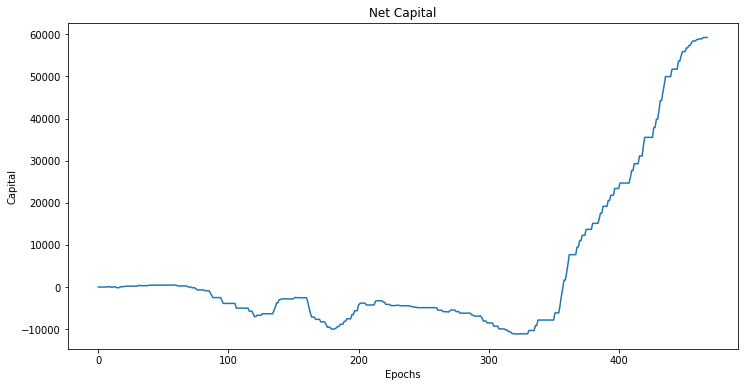

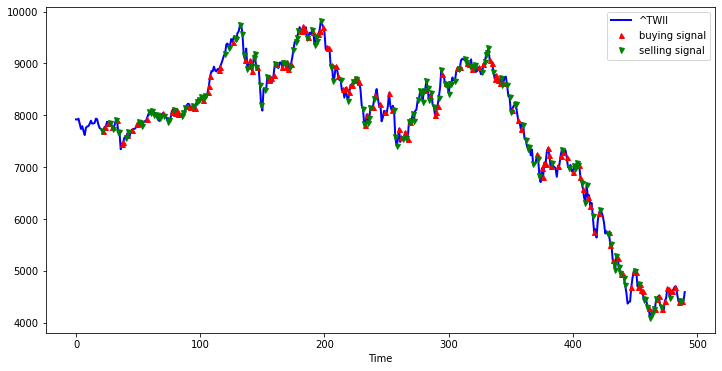

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 7/75

Closed Profit $ 57264.7   Current Profit: $ 164738.9
########################
TOTAL PROFIT: $ 164738.9. Time taken for 1 episode: 42.27 secs
########################


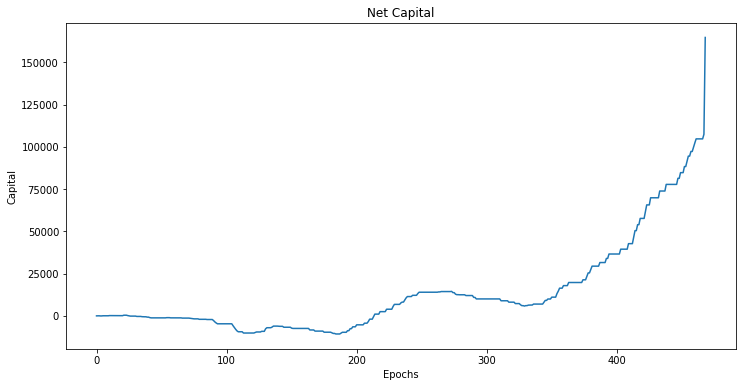

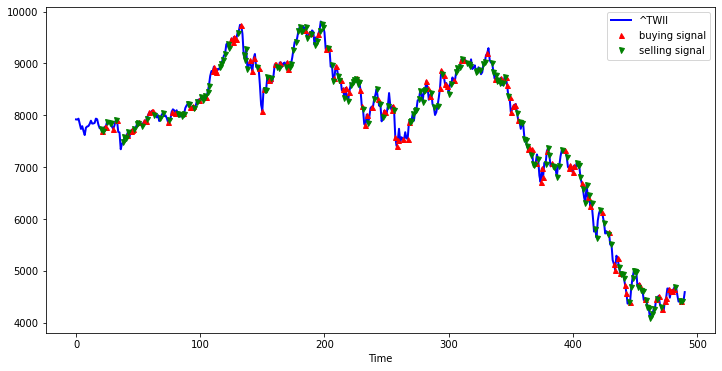

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 8/75

Closed Profit $ 291.5   Current Profit: - $ 22855.3
########################
TOTAL PROFIT: - $ 22855.3. Time taken for 1 episode: 41.94 secs
########################


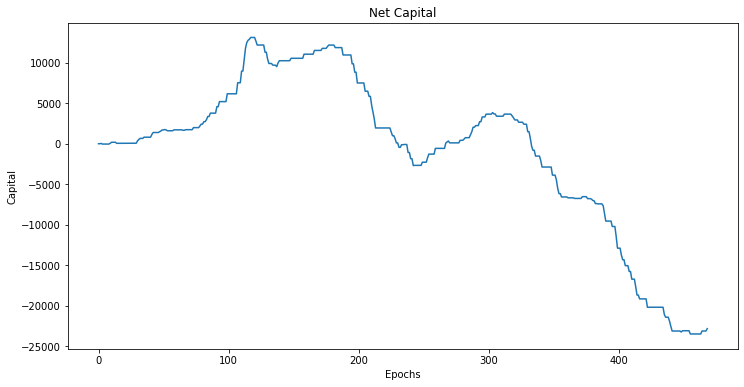

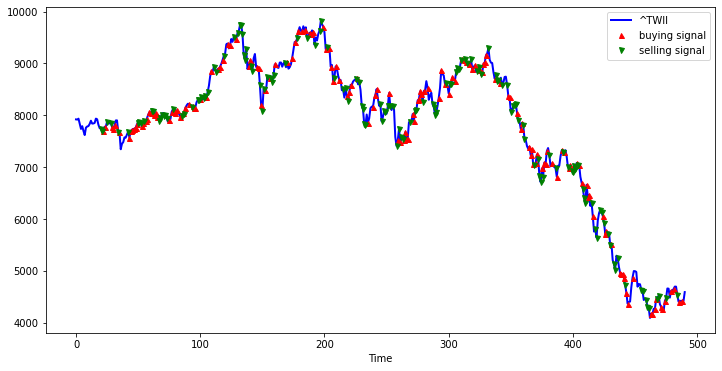

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 9/75

Closed Profit $ 905.6   Current Profit: $ 8120.5
########################
TOTAL PROFIT: $ 8120.5. Time taken for 1 episode: 41.78 secs
########################


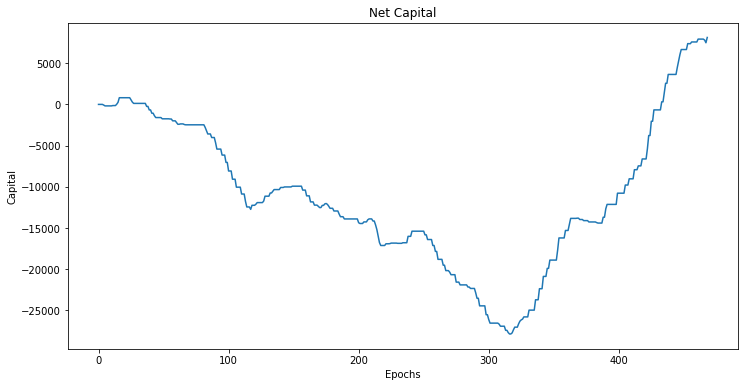

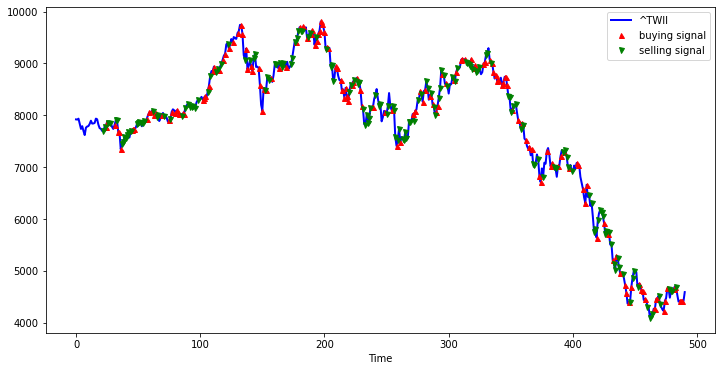

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 10/75

Closed Profit $ 2249.2   Current Profit: $ 2322.7
########################
TOTAL PROFIT: $ 2322.7. Time taken for 1 episode: 41.63 secs
########################


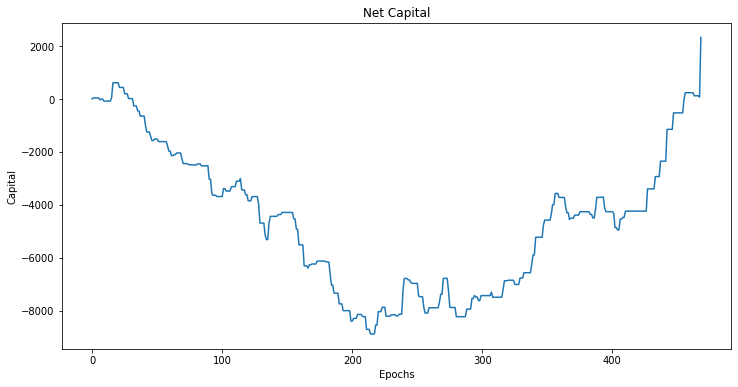

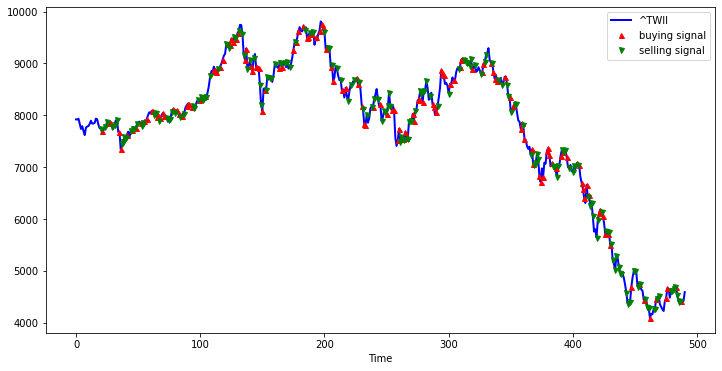

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 11/75

Closed Profit $ 1921.3   Current Profit: $ 104828.2
########################
TOTAL PROFIT: $ 104828.2. Time taken for 1 episode: 41.67 secs
########################


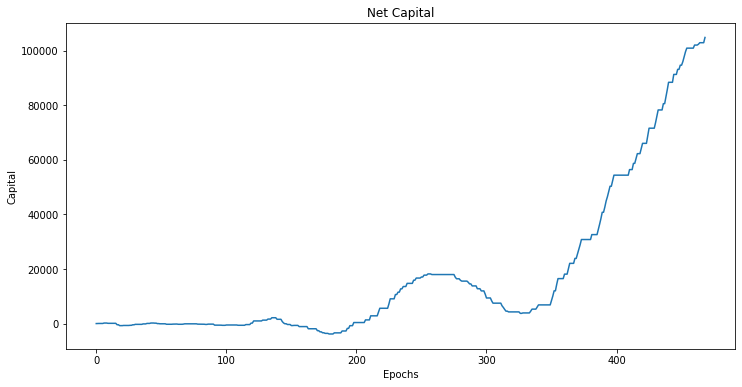

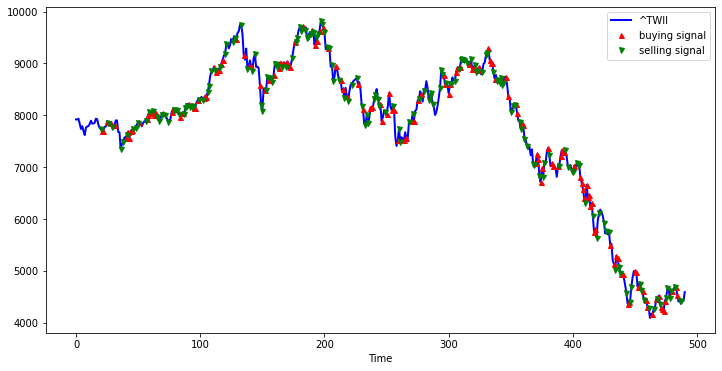

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 12/75

Closed Profit - $ 13.2   Current Profit: - $ 37200.0
########################
TOTAL PROFIT: - $ 37200.0. Time taken for 1 episode: 41.85 secs
########################


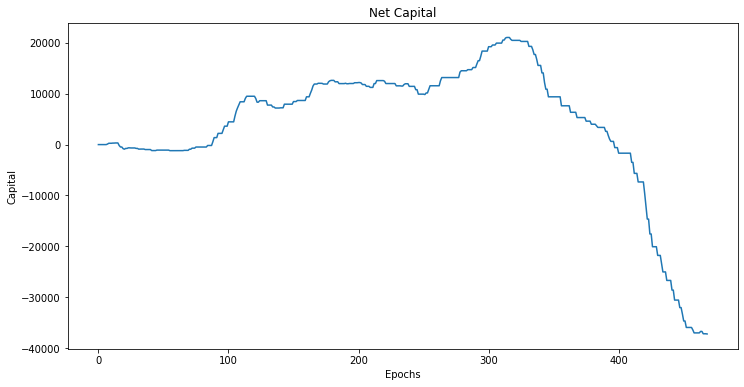

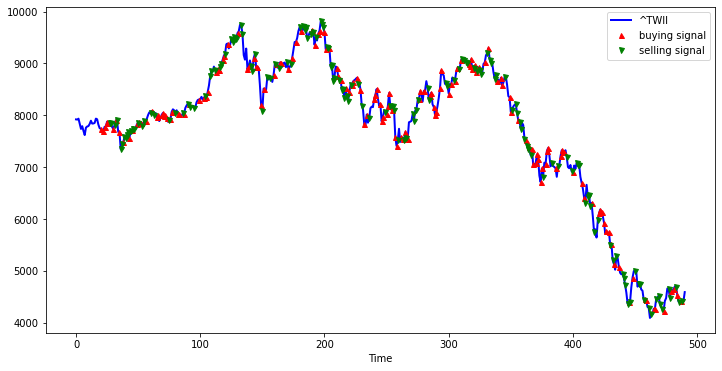

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 13/75

Closed Profit - $ 19.2   Current Profit: - $ 9777.2
########################
TOTAL PROFIT: - $ 9777.2. Time taken for 1 episode: 42.36 secs
########################


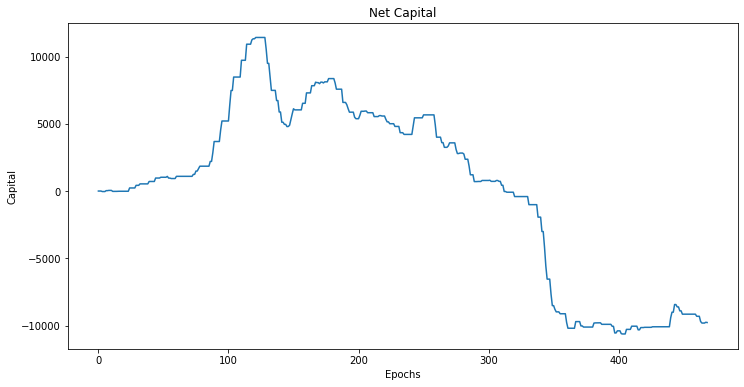

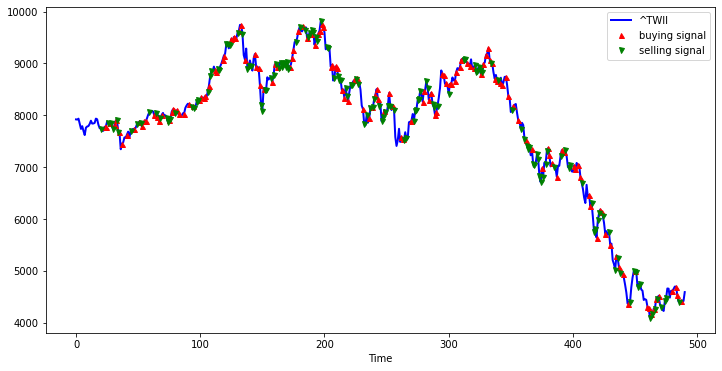

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 14/75

Closed Profit - $ 11.6   Current Profit: $ 15384.3
########################
TOTAL PROFIT: $ 15384.3. Time taken for 1 episode: 41.93 secs
########################


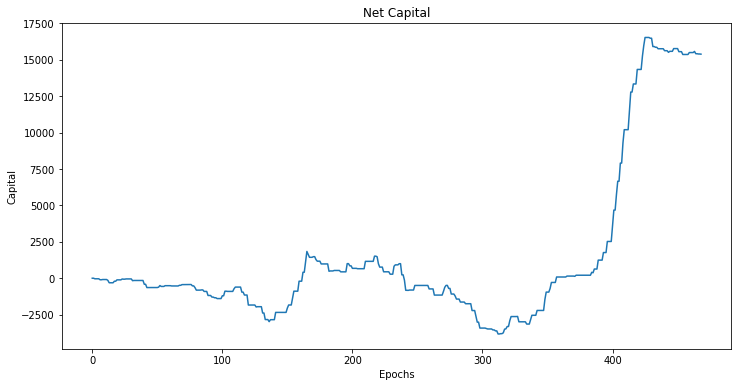

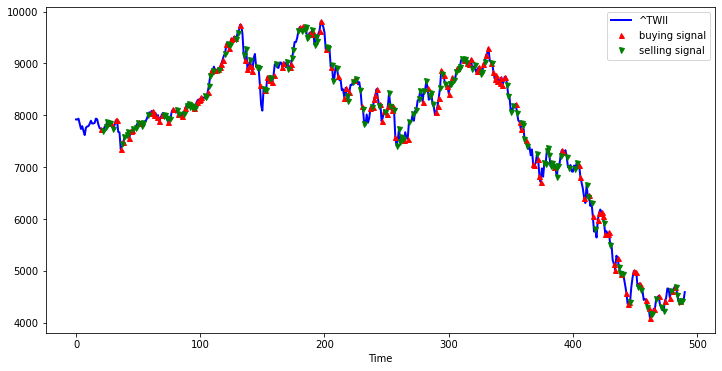

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 15/75

Closed Profit $ 75.0   Current Profit: $ 24733.1
########################
TOTAL PROFIT: $ 24733.1. Time taken for 1 episode: 42.41 secs
########################


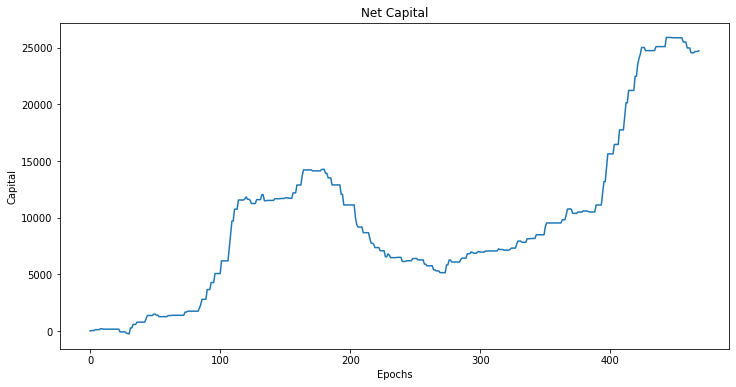

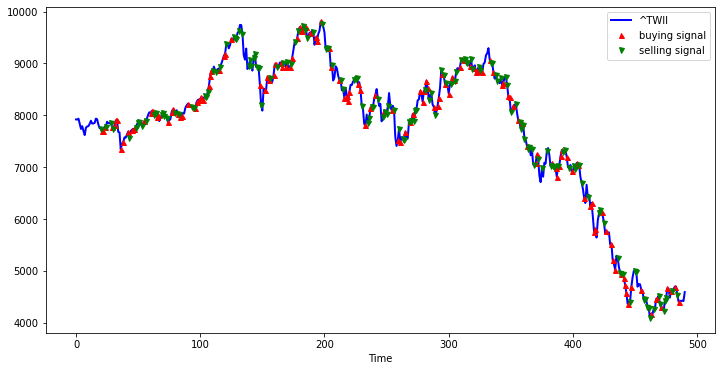

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 16/75

Closed Profit - $ 273.1   Current Profit: - $ 31218.4
########################
TOTAL PROFIT: - $ 31218.4. Time taken for 1 episode: 41.46 secs
########################


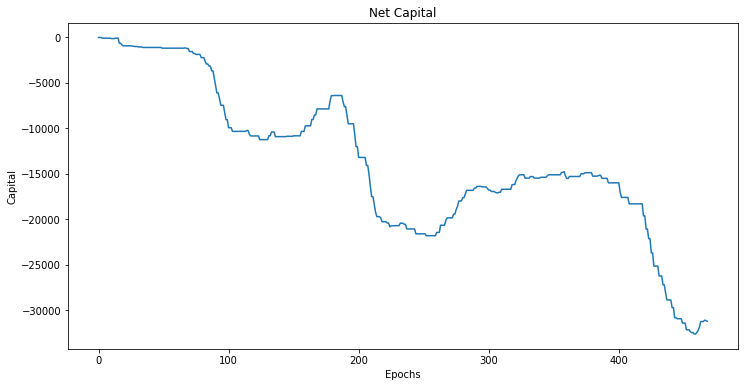

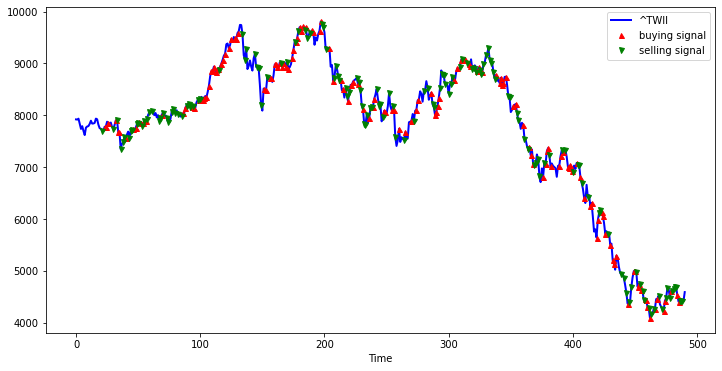

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 17/75

Closed Profit $ 968.4   Current Profit: $ 69392.5
########################
TOTAL PROFIT: $ 69392.5. Time taken for 1 episode: 41.54 secs
########################


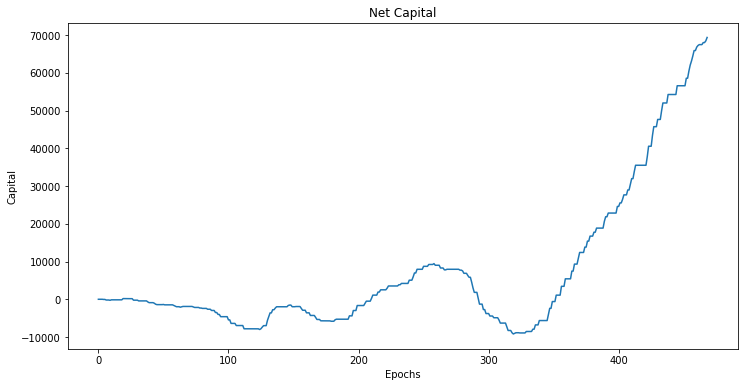

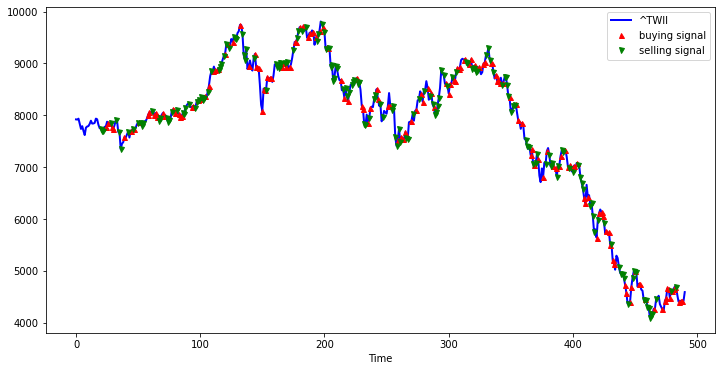

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 18/75

Closed Profit $ 506.0   Current Profit: $ 14583.6
########################
TOTAL PROFIT: $ 14583.6. Time taken for 1 episode: 41.85 secs
########################


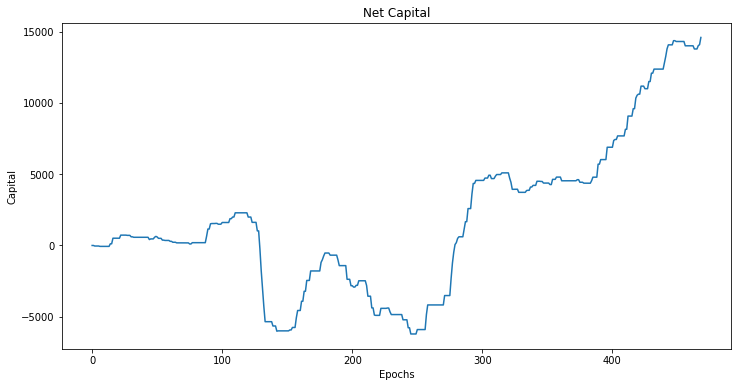

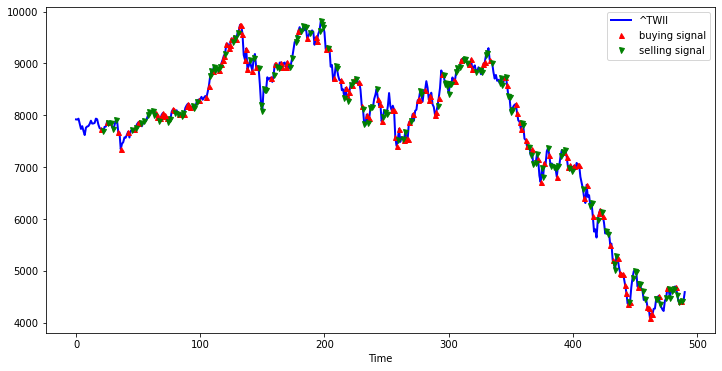

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 19/75

Closed Profit - $ 1004.2   Current Profit: - $ 37378.5
########################
TOTAL PROFIT: - $ 37378.5. Time taken for 1 episode: 41.35 secs
########################


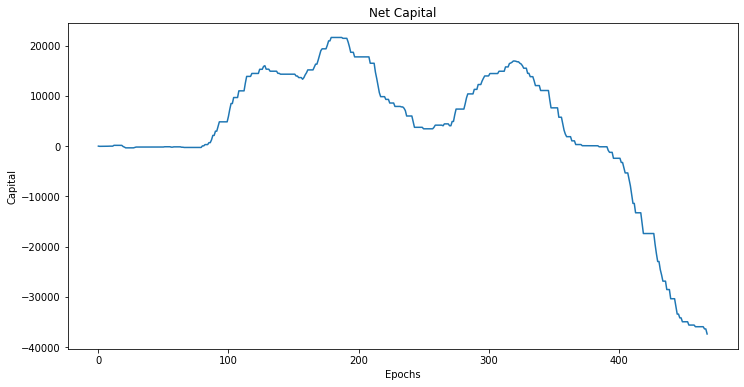

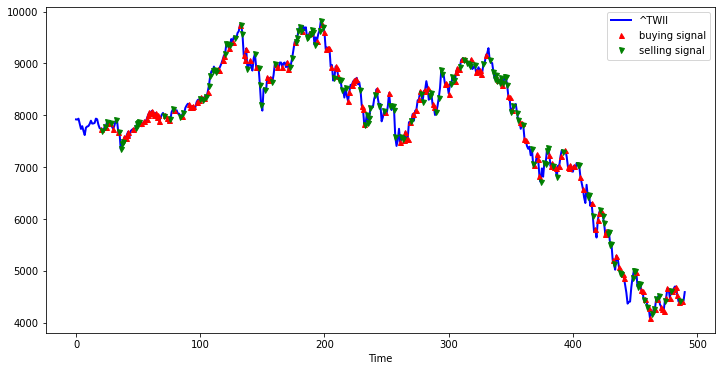

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 20/75

Closed Profit - $ 49.9   Current Profit: $ 3914.0
########################
TOTAL PROFIT: $ 3914.0. Time taken for 1 episode: 43.84 secs
########################


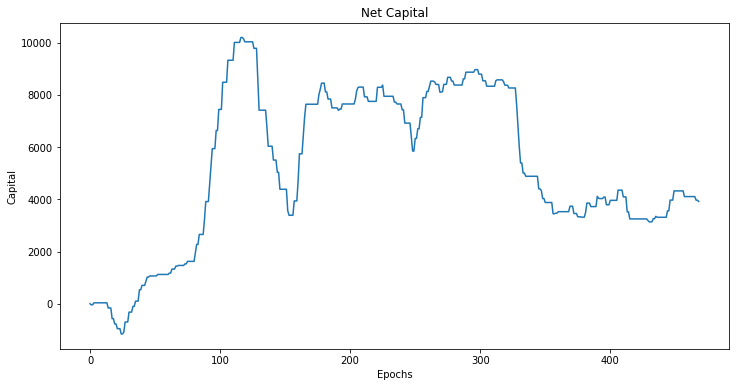

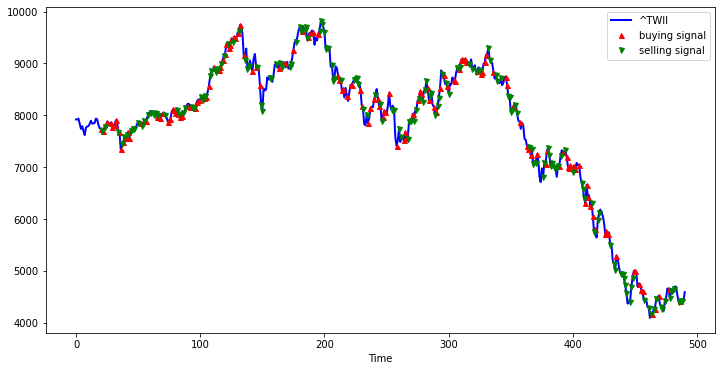

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 21/75

Closed Profit $ 1170.9   Current Profit: - $ 35887.2
########################
TOTAL PROFIT: - $ 35887.2. Time taken for 1 episode: 42.32 secs
########################


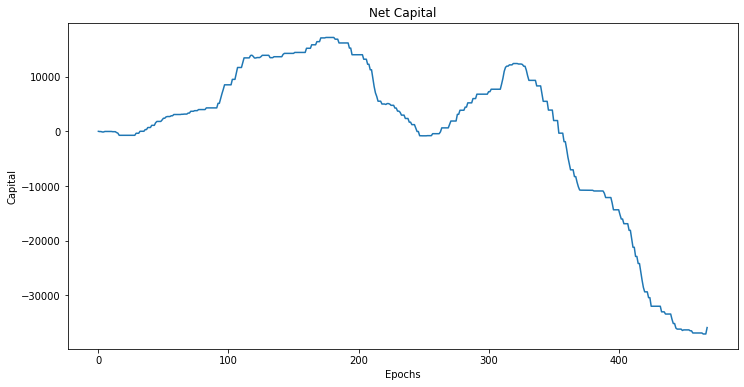

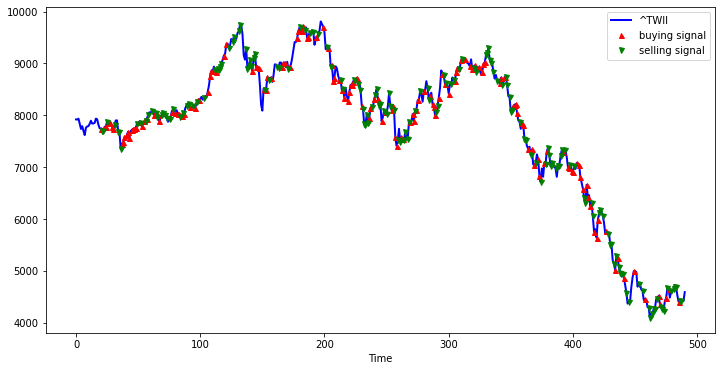

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 22/75

Closed Profit - $ 692.0   Current Profit: $ 802.8
########################
TOTAL PROFIT: $ 802.8. Time taken for 1 episode: 43.14 secs
########################


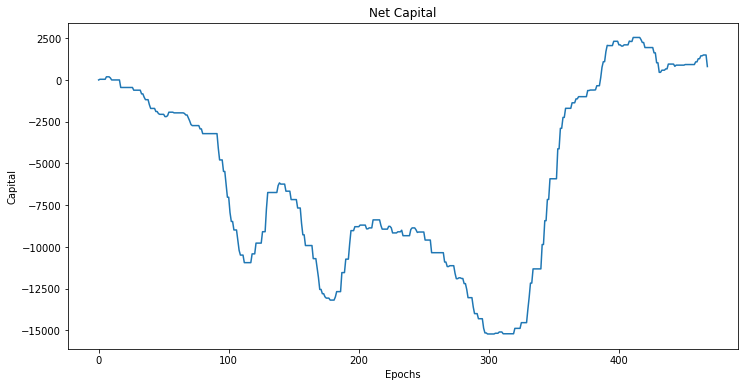

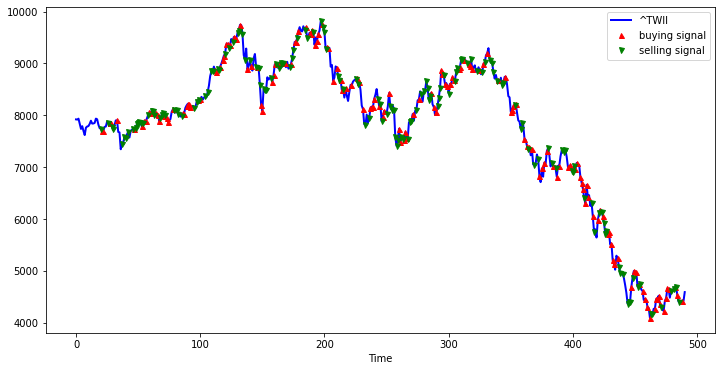

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 23/75

Closed Profit - $ 2663.6   Current Profit: - $ 70947.9
########################
TOTAL PROFIT: - $ 70947.9. Time taken for 1 episode: 43.96 secs
########################


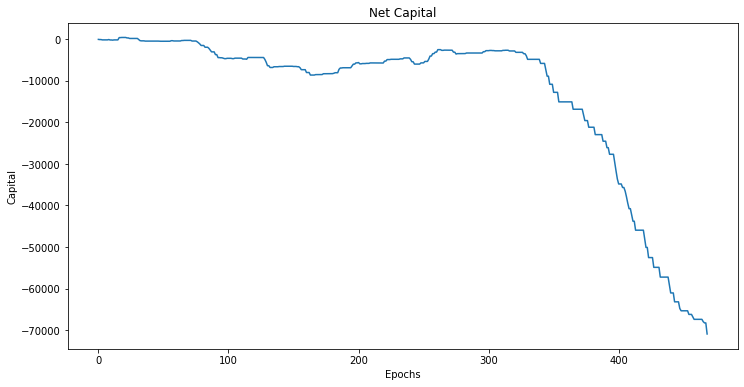

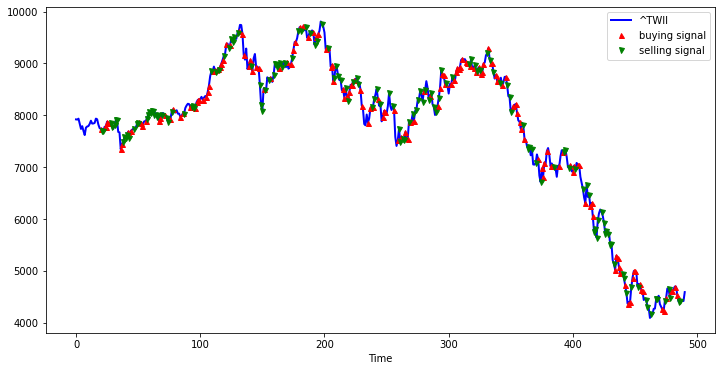

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 24/75

Closed Profit $ 408.2   Current Profit: $ 19371.7
########################
TOTAL PROFIT: $ 19371.7. Time taken for 1 episode: 42.23 secs
########################


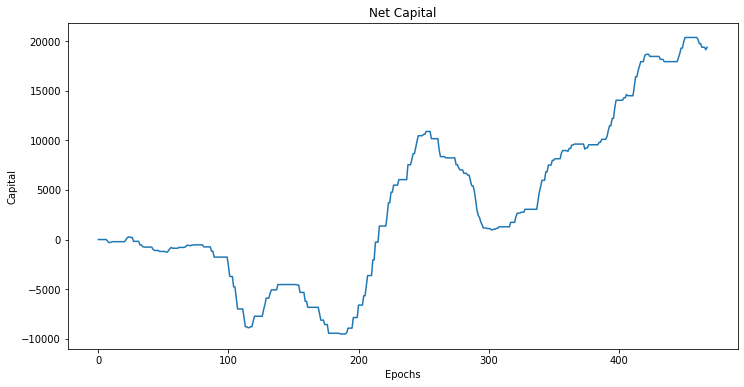

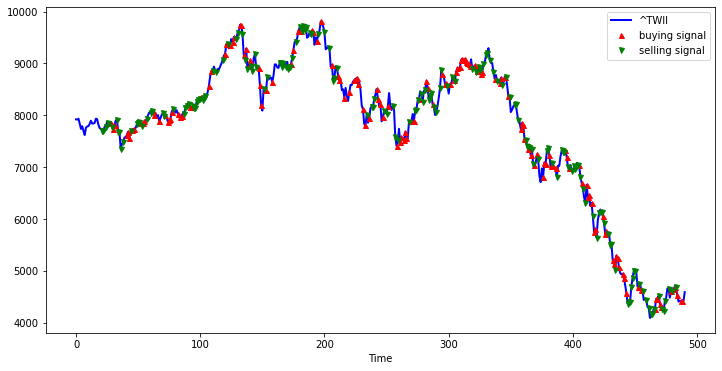

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 25/75

Closed Profit $ 3664.9   Current Profit: $ 53448.3
########################
TOTAL PROFIT: $ 53448.3. Time taken for 1 episode: 43.76 secs
########################


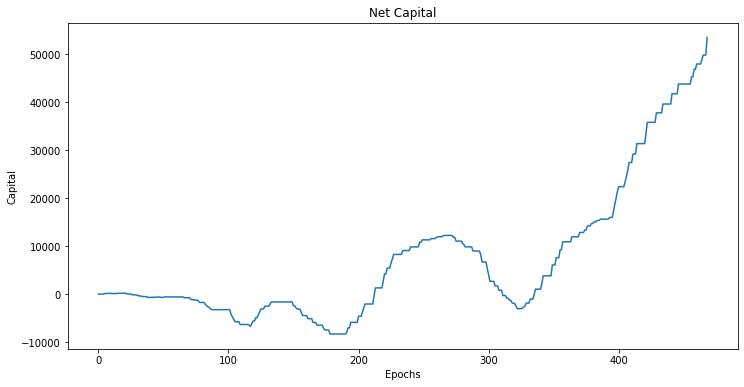

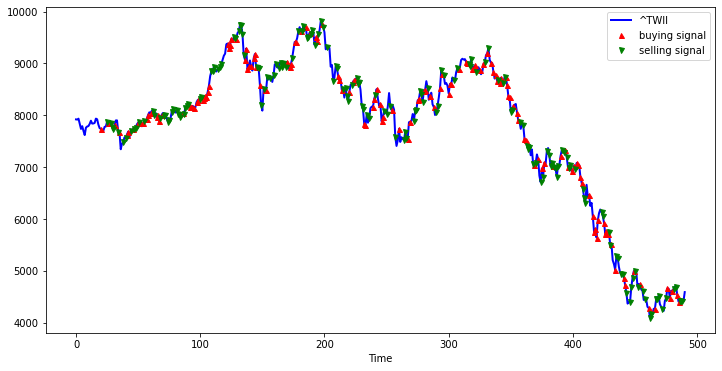

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 26/75

Closed Profit - $ 768.8   Current Profit: - $ 7617.3
########################
TOTAL PROFIT: - $ 7617.3. Time taken for 1 episode: 43.67 secs
########################


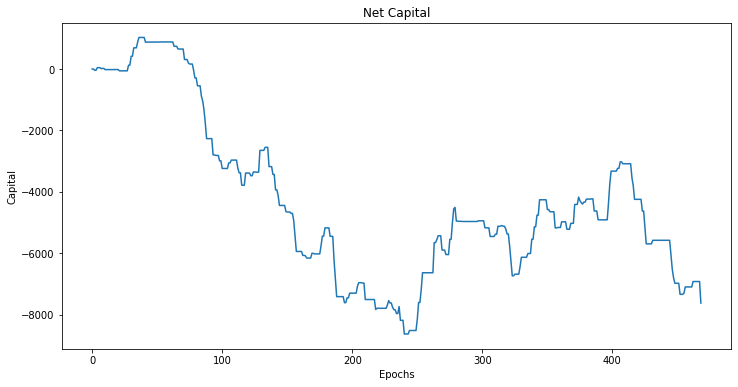

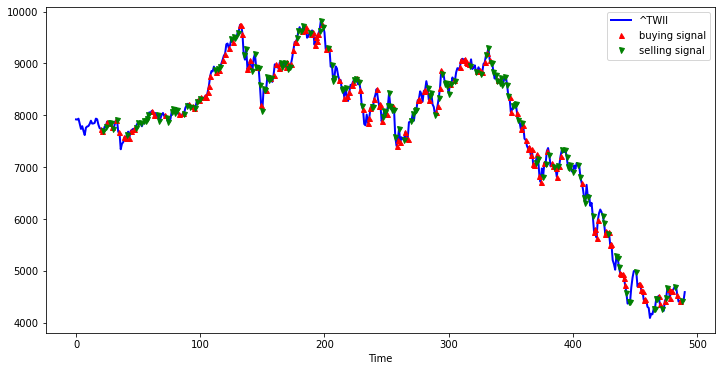

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 27/75

Closed Profit $ 1635.0   Current Profit: $ 49003.3
########################
TOTAL PROFIT: $ 49003.3. Time taken for 1 episode: 42.52 secs
########################


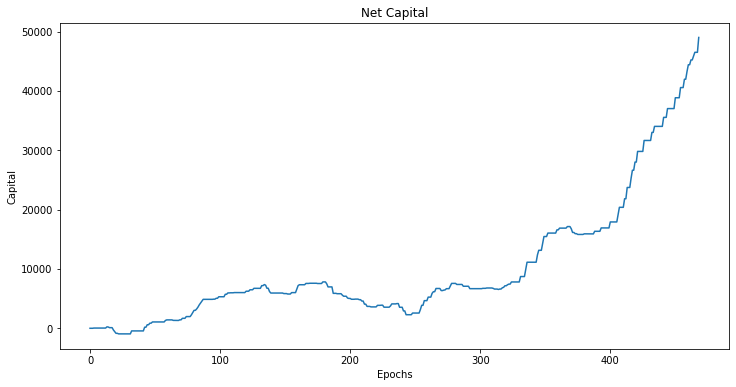

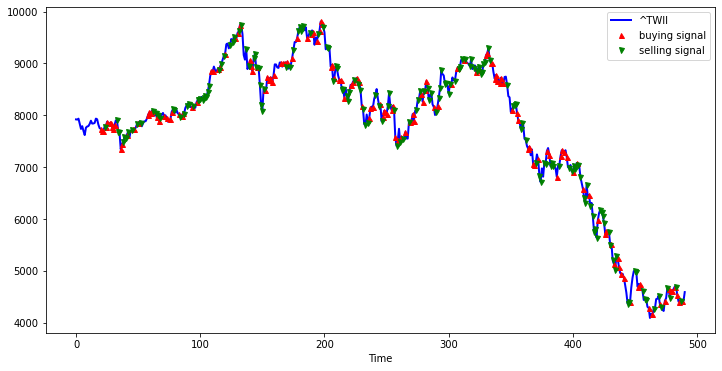

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 28/75

Closed Profit - $ 12972.4   Current Profit: - $ 83842.7
########################
TOTAL PROFIT: - $ 83842.7. Time taken for 1 episode: 42.17 secs
########################


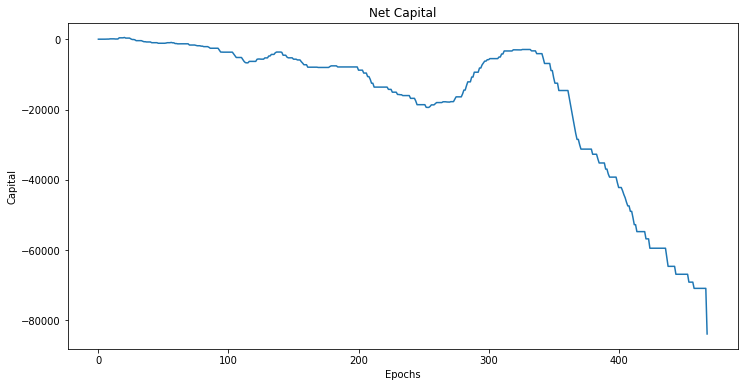

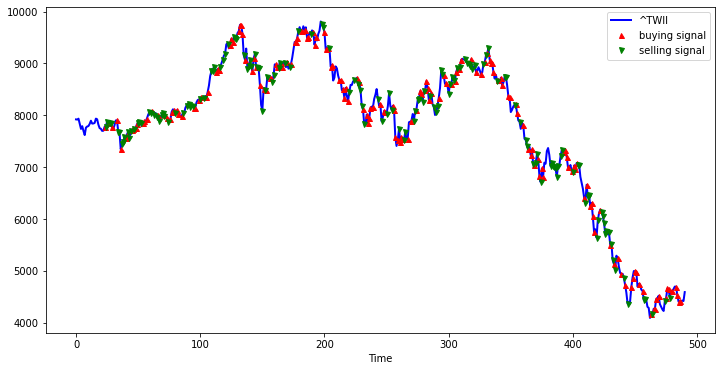

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 29/75

Closed Profit - $ 6613.9   Current Profit: - $ 78638.4
########################
TOTAL PROFIT: - $ 78638.4. Time taken for 1 episode: 41.86 secs
########################


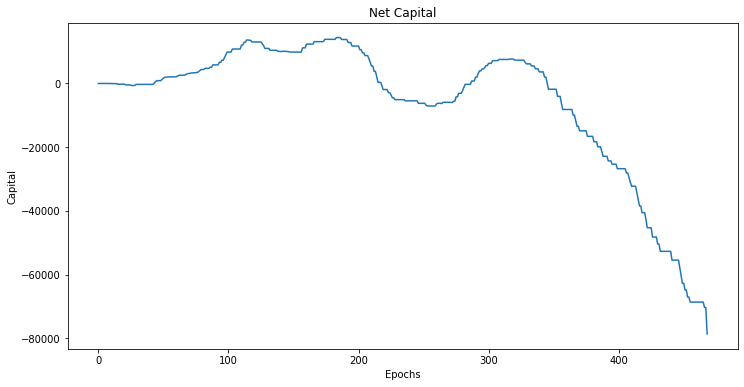

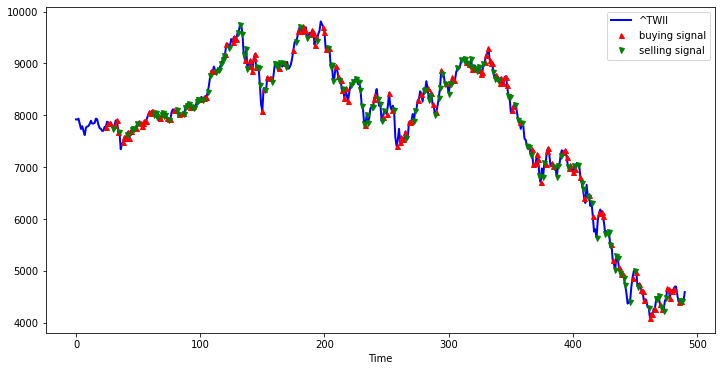

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 30/75

Closed Profit $ 2155.3   Current Profit: $ 52637.0
########################
TOTAL PROFIT: $ 52637.0. Time taken for 1 episode: 41.67 secs
########################


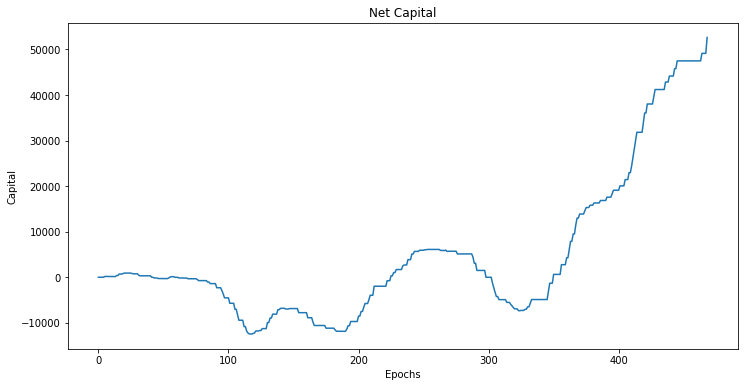

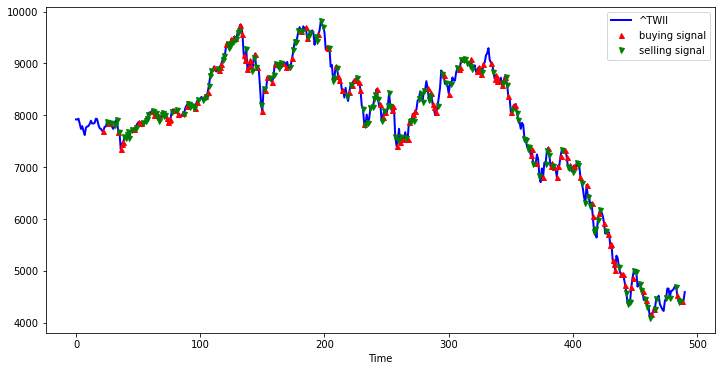

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 31/75

Closed Profit - $ 356.5   Current Profit: - $ 14098.9
########################
TOTAL PROFIT: - $ 14098.9. Time taken for 1 episode: 42.01 secs
########################


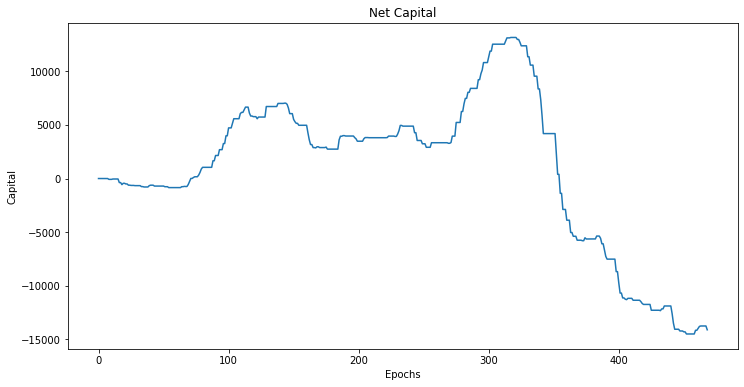

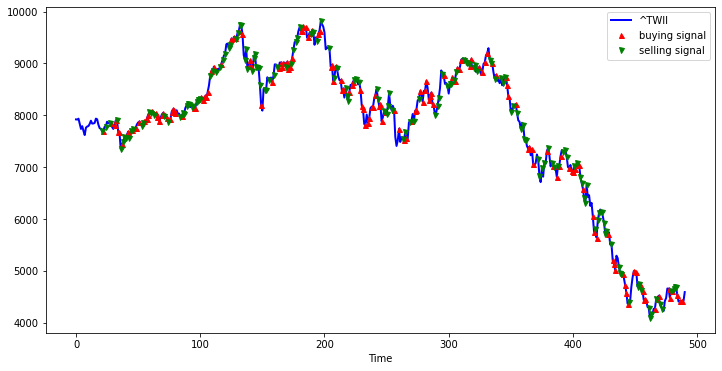

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 32/75

Closed Profit $ 173.9   Current Profit: $ 19058.2
########################
TOTAL PROFIT: $ 19058.2. Time taken for 1 episode: 42.09 secs
########################


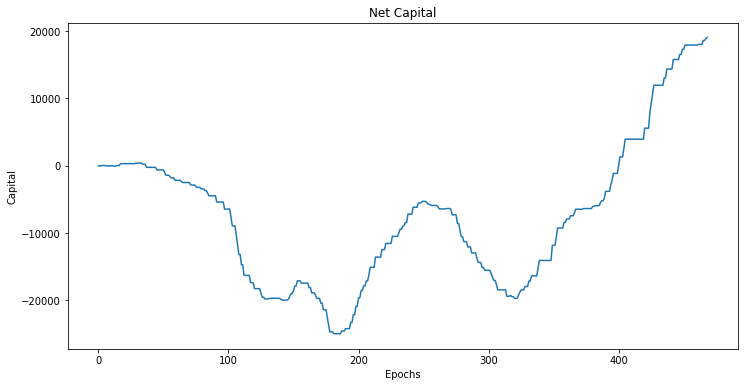

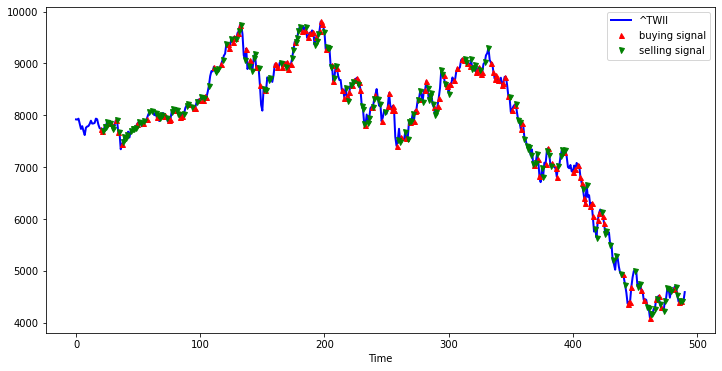

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 33/75

Closed Profit $ 16.4   Current Profit: - $ 34951.8
########################
TOTAL PROFIT: - $ 34951.8. Time taken for 1 episode: 41.99 secs
########################


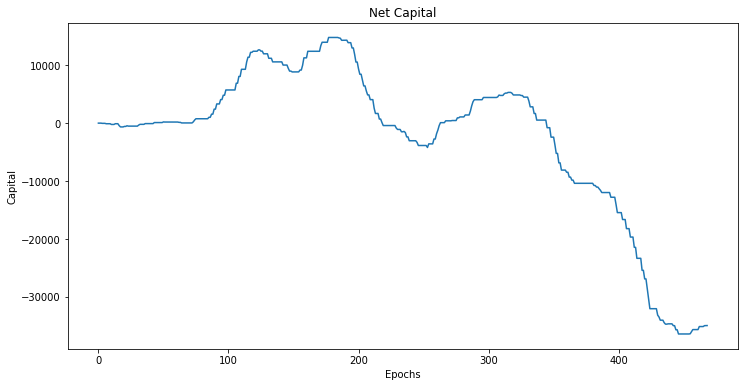

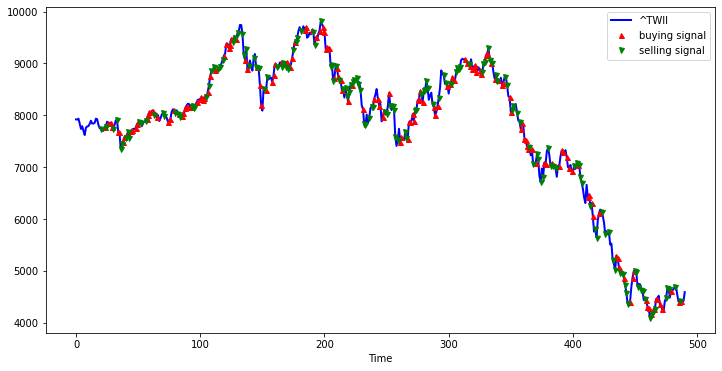

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 34/75

Closed Profit $ 77.8   Current Profit: $ 20762.6
########################
TOTAL PROFIT: $ 20762.6. Time taken for 1 episode: 41.45 secs
########################


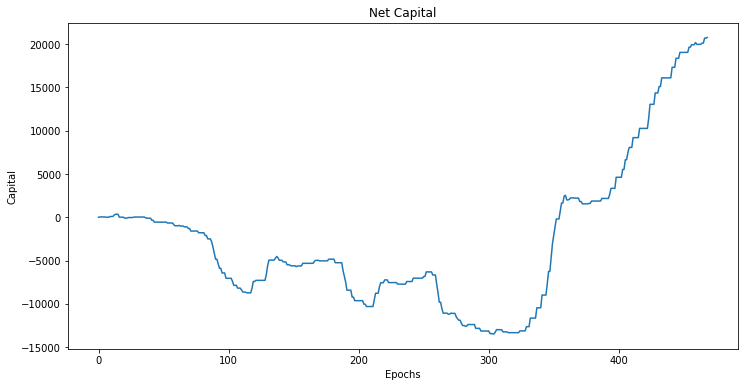

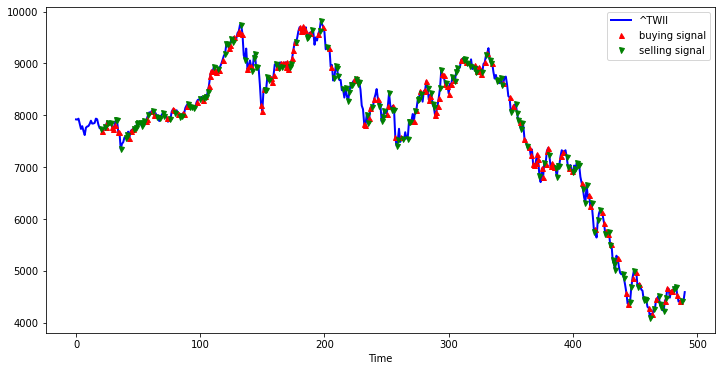

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 35/75

Closed Profit - $ 846.7   Current Profit: - $ 11950.1
########################
TOTAL PROFIT: - $ 11950.1. Time taken for 1 episode: 42.2 secs
########################


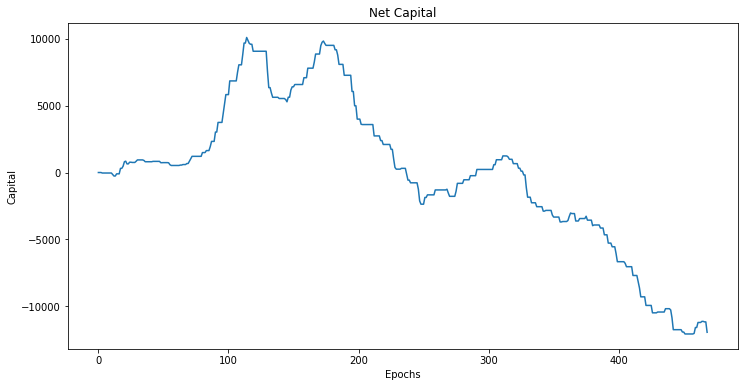

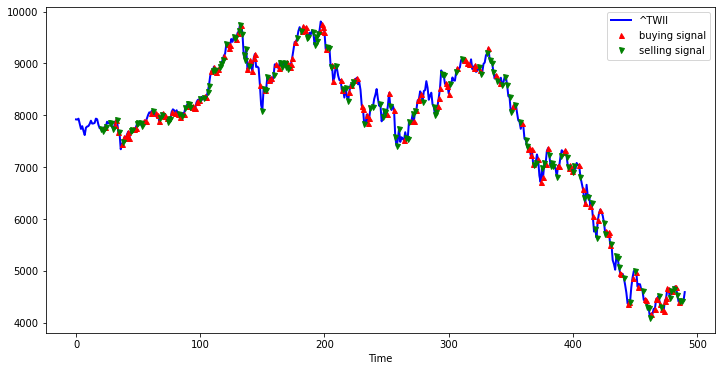

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 36/75

Closed Profit - $ 10111.6   Current Profit: - $ 55765.3
########################
TOTAL PROFIT: - $ 55765.3. Time taken for 1 episode: 42.08 secs
########################


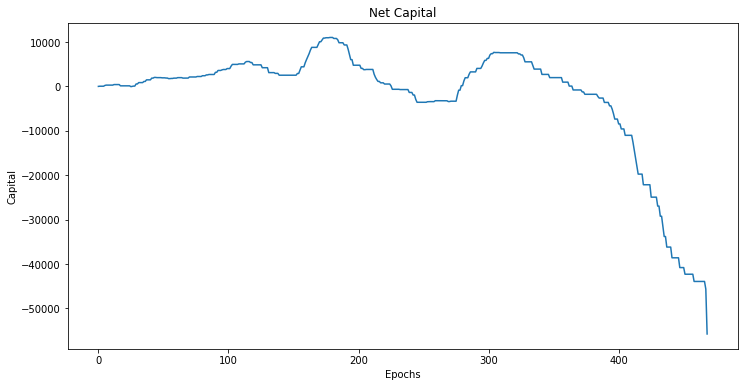

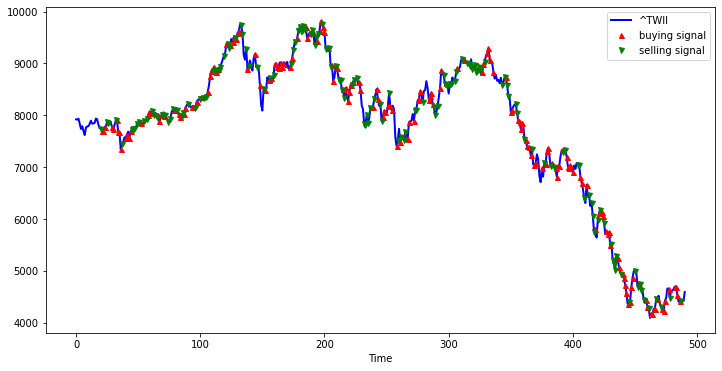

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 37/75

Closed Profit $ 3043.3   Current Profit: $ 111749.9
########################
TOTAL PROFIT: $ 111749.9. Time taken for 1 episode: 42.33 secs
########################


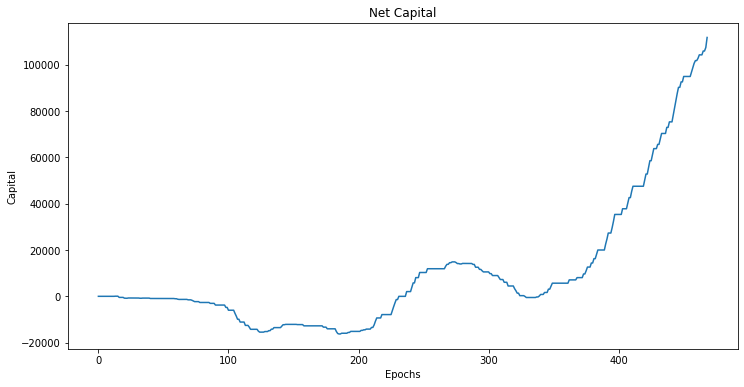

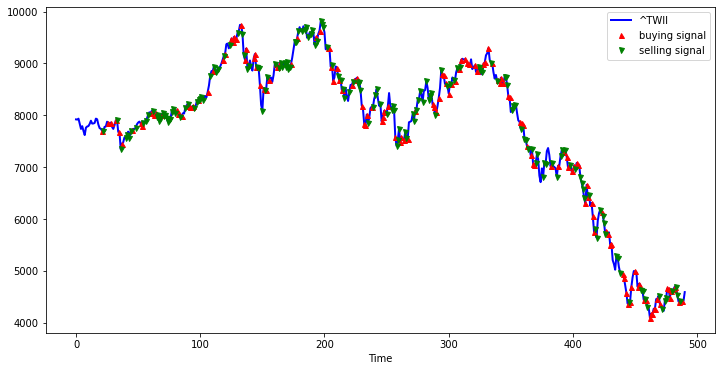

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 38/75

Closed Profit - $ 5122.9   Current Profit: - $ 51099.3
########################
TOTAL PROFIT: - $ 51099.3. Time taken for 1 episode: 41.27 secs
########################


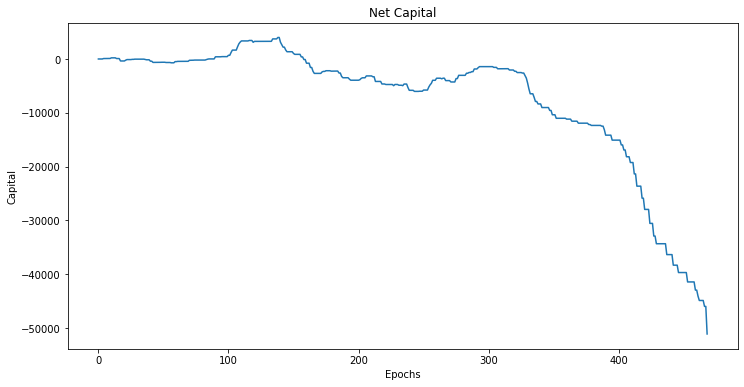

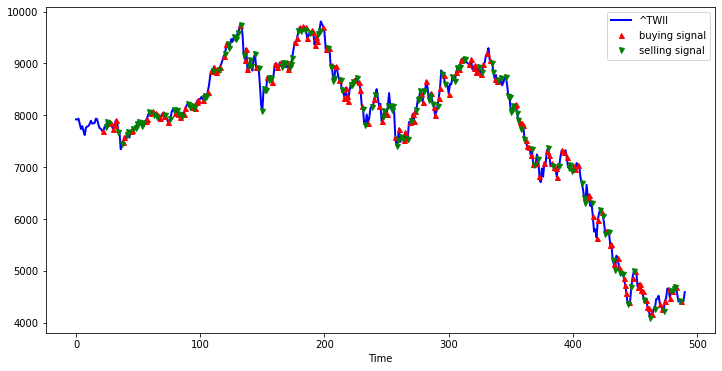

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 39/75

Closed Profit $ 12398.5   Current Profit: $ 80836.6
########################
TOTAL PROFIT: $ 80836.6. Time taken for 1 episode: 41.25 secs
########################


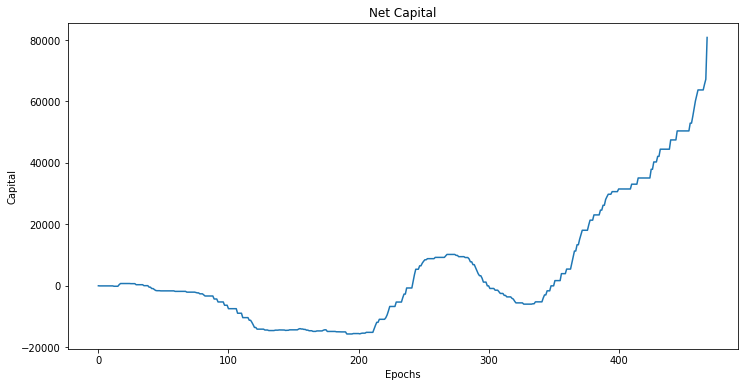

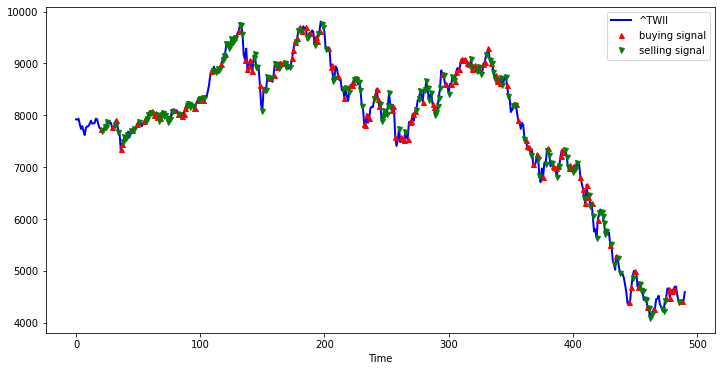

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 40/75

Closed Profit $ 10840.0   Current Profit: $ 87421.5
########################
TOTAL PROFIT: $ 87421.5. Time taken for 1 episode: 42.2 secs
########################


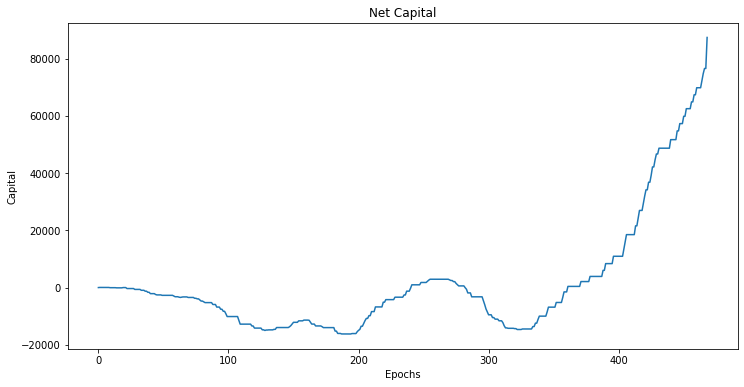

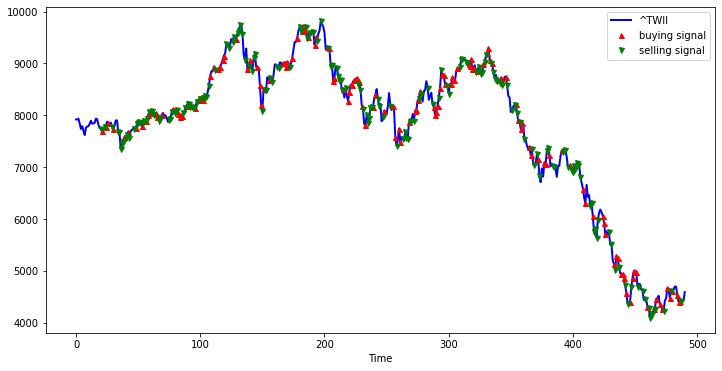

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 41/75

Closed Profit $ 195.0   Current Profit: - $ 68403.5
########################
TOTAL PROFIT: - $ 68403.5. Time taken for 1 episode: 41.61 secs
########################


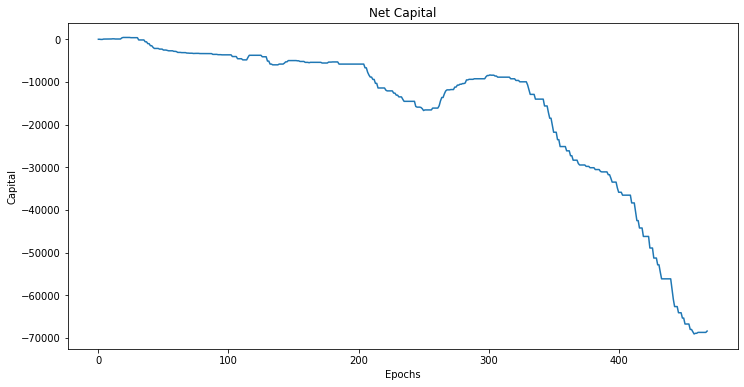

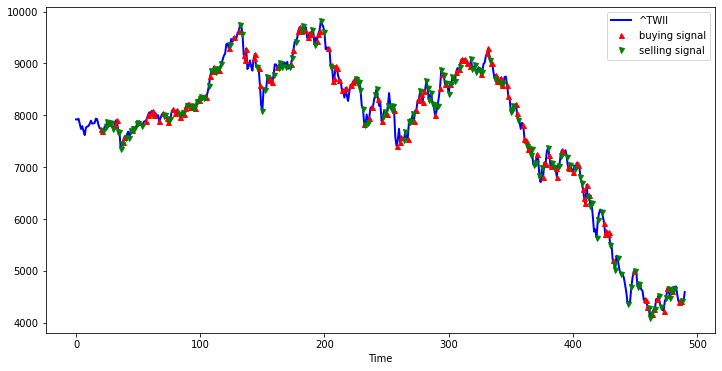

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 42/75

Closed Profit - $ 12296.5   Current Profit: - $ 104486.4
########################
TOTAL PROFIT: - $ 104486.4. Time taken for 1 episode: 42.65 secs
########################


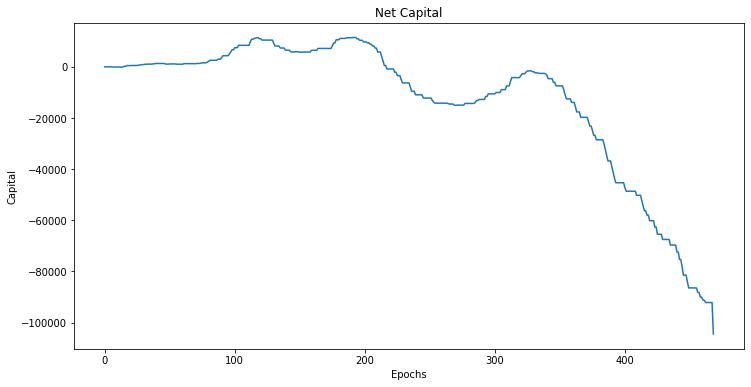

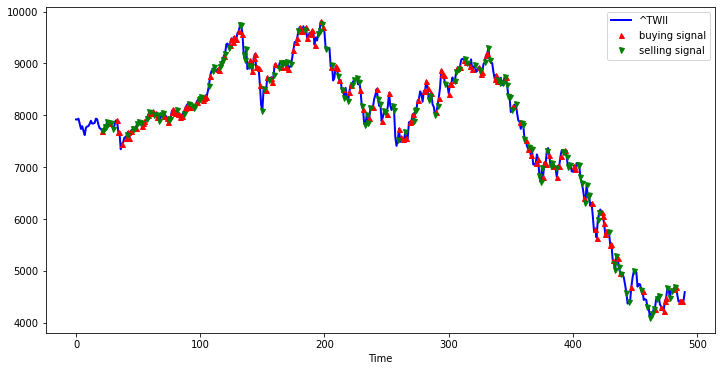

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 43/75

Closed Profit - $ 23504.8   Current Profit: - $ 98314.4
########################
TOTAL PROFIT: - $ 98314.4. Time taken for 1 episode: 42.23 secs
########################


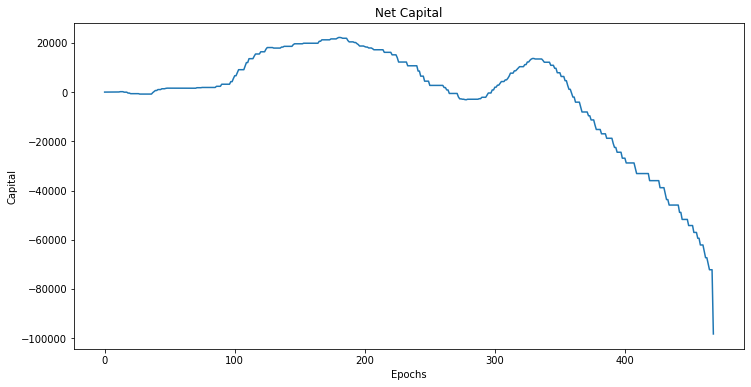

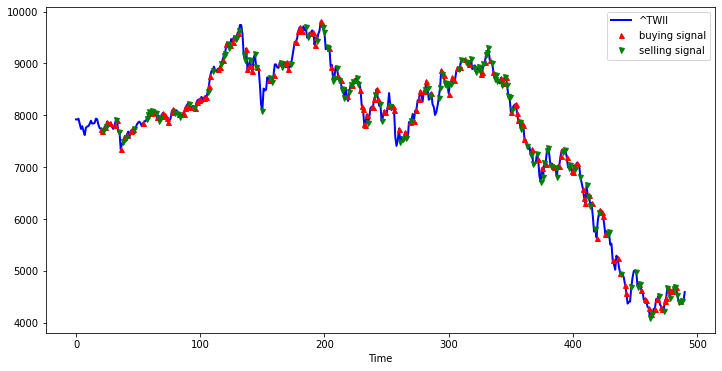

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 44/75

Closed Profit - $ 492.4   Current Profit: - $ 36766.2
########################
TOTAL PROFIT: - $ 36766.2. Time taken for 1 episode: 41.96 secs
########################


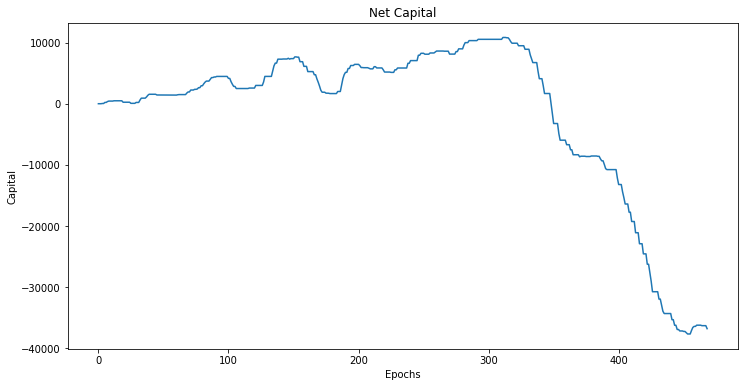

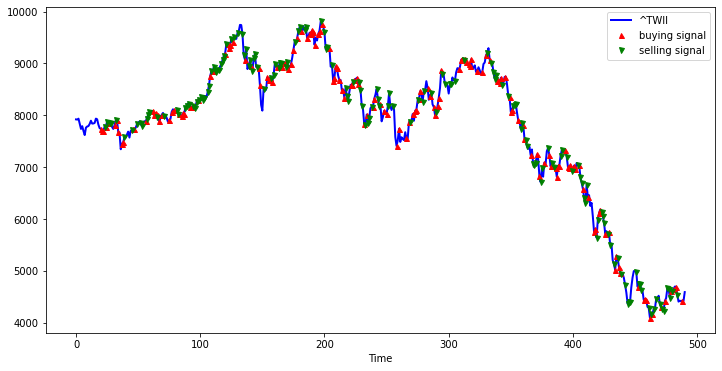

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 45/75

Closed Profit $ 866.3   Current Profit: - $ 1116.9
########################
TOTAL PROFIT: - $ 1116.9. Time taken for 1 episode: 42.17 secs
########################


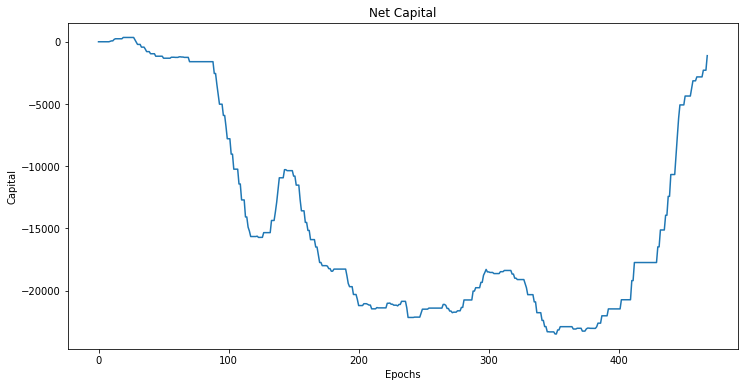

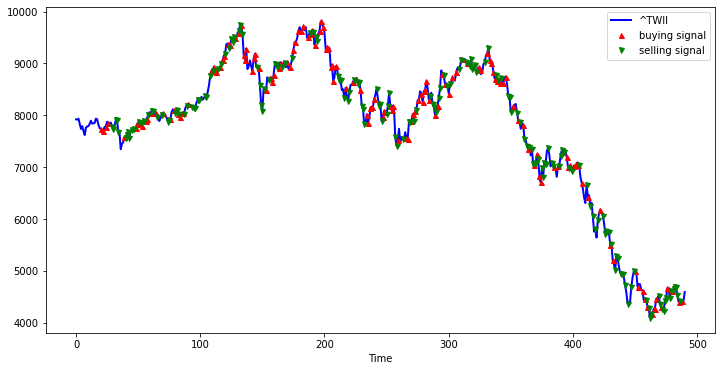

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 46/75

Closed Profit $ 339.0   Current Profit: $ 53384.0
########################
TOTAL PROFIT: $ 53384.0. Time taken for 1 episode: 43.13 secs
########################


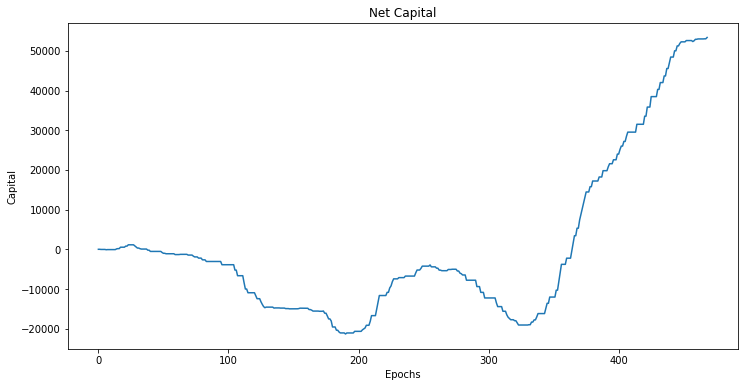

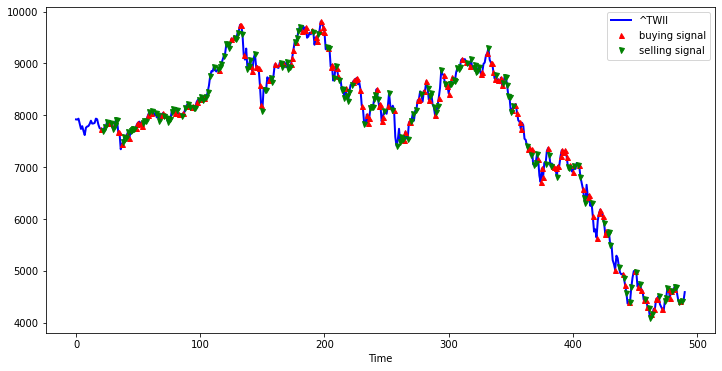

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 47/75

Closed Profit $ 30.9   Current Profit: $ 842.3
########################
TOTAL PROFIT: $ 842.3. Time taken for 1 episode: 42.02 secs
########################


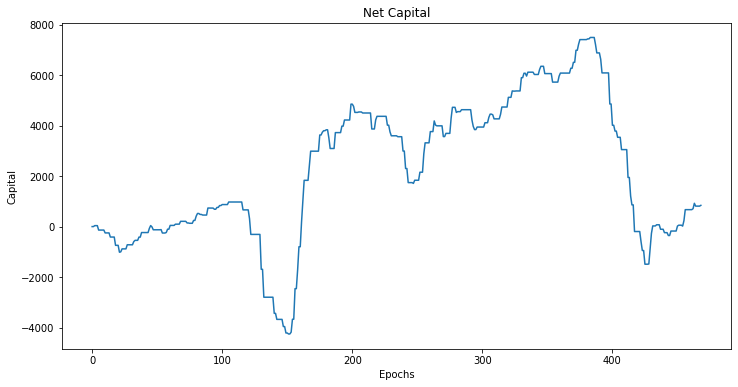

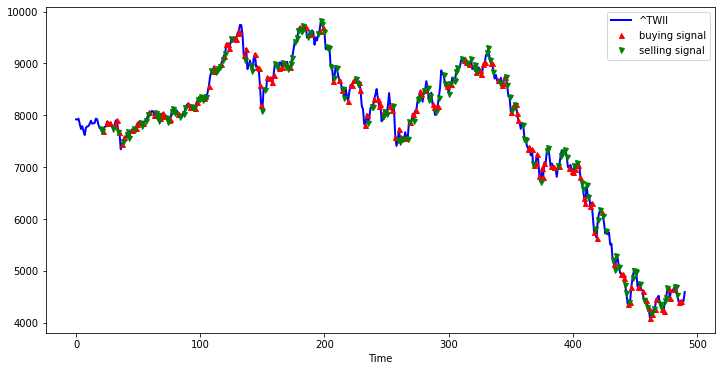

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 48/75

Closed Profit $ 308.8   Current Profit: $ 55980.1
########################
TOTAL PROFIT: $ 55980.1. Time taken for 1 episode: 41.86 secs
########################


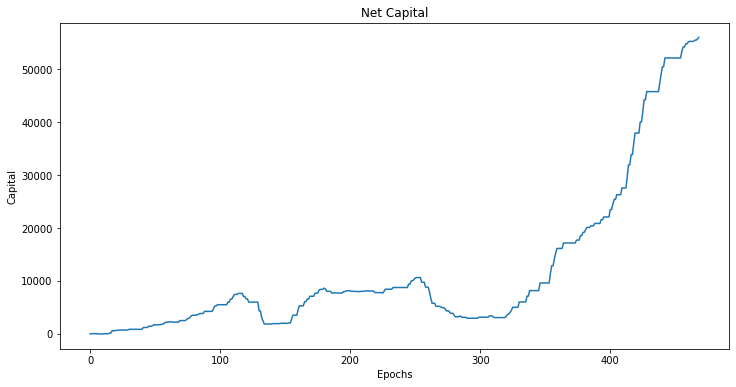

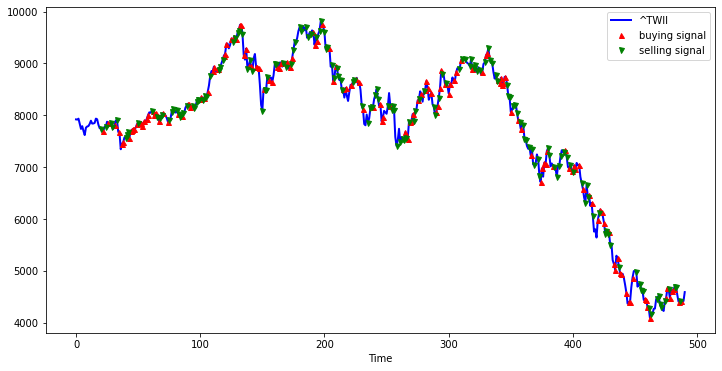

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 49/75

Closed Profit $ 856.2   Current Profit: $ 5923.3
########################
TOTAL PROFIT: $ 5923.3. Time taken for 1 episode: 41.91 secs
########################


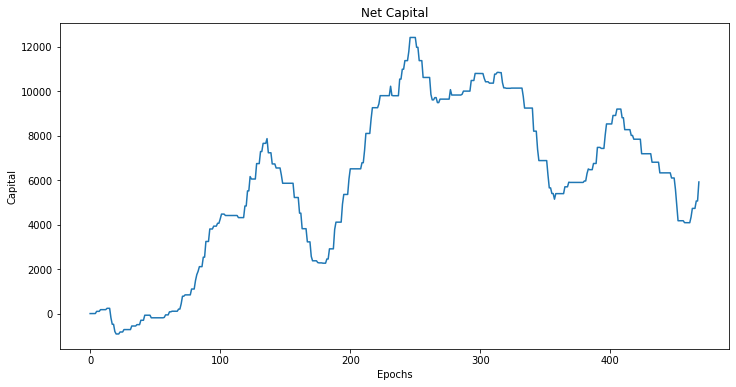

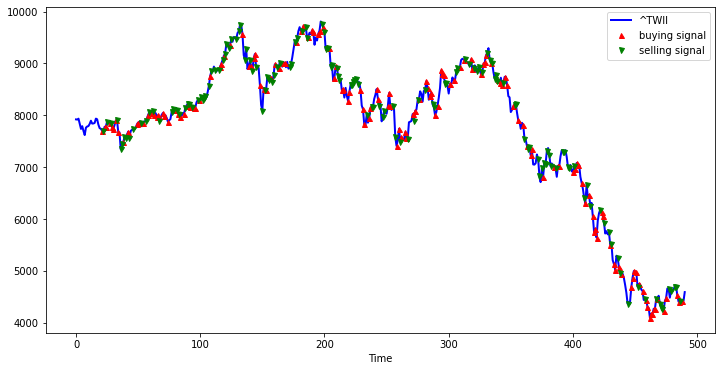

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 50/75

Closed Profit - $ 527.5   Current Profit: $ 21209.8
########################
TOTAL PROFIT: $ 21209.8. Time taken for 1 episode: 41.5 secs
########################


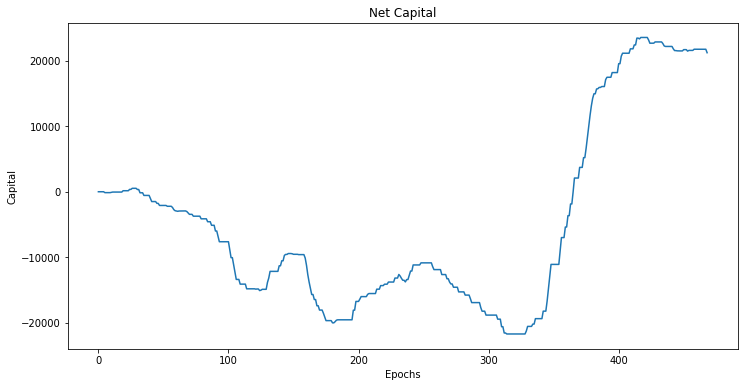

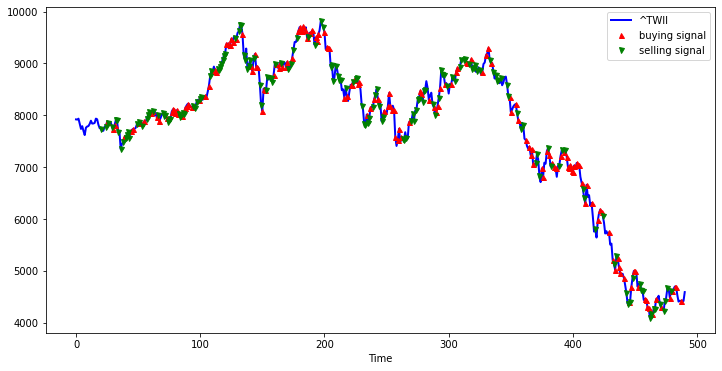

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 51/75

Closed Profit - $ 96.8   Current Profit: - $ 13637.9
########################
TOTAL PROFIT: - $ 13637.9. Time taken for 1 episode: 41.51 secs
########################


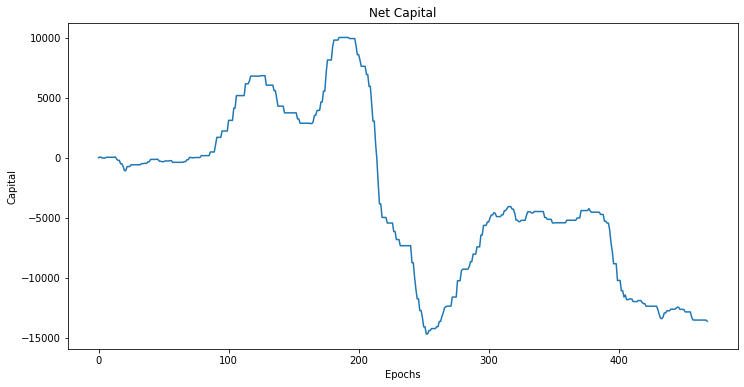

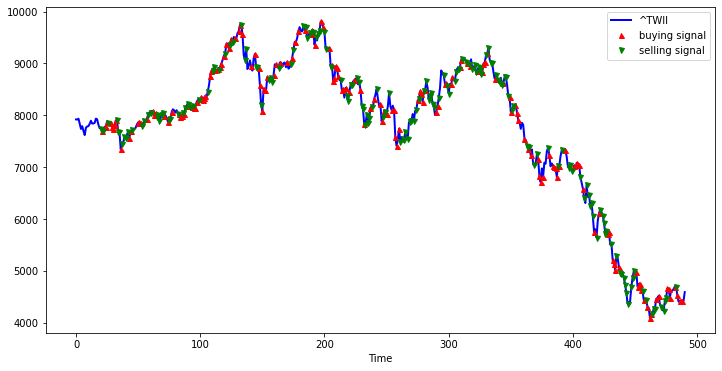

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 52/75

Closed Profit $ 581.0   Current Profit: $ 11618.3
########################
TOTAL PROFIT: $ 11618.3. Time taken for 1 episode: 41.78 secs
########################


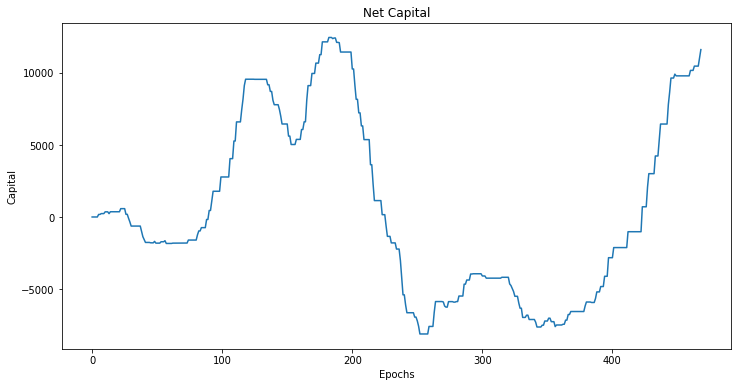

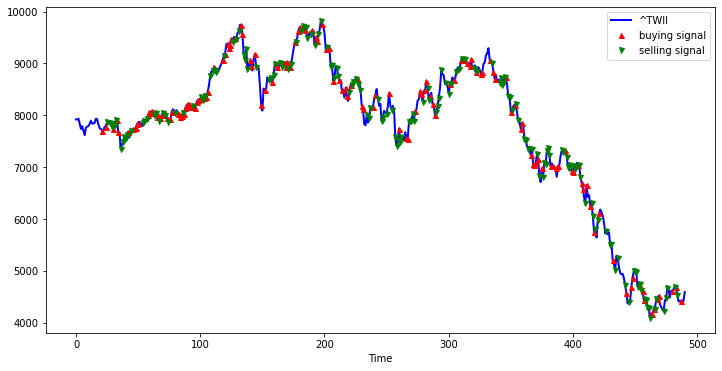

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 53/75

Closed Profit $ 12857.8   Current Profit: $ 103038.4
########################
TOTAL PROFIT: $ 103038.4. Time taken for 1 episode: 41.94 secs
########################


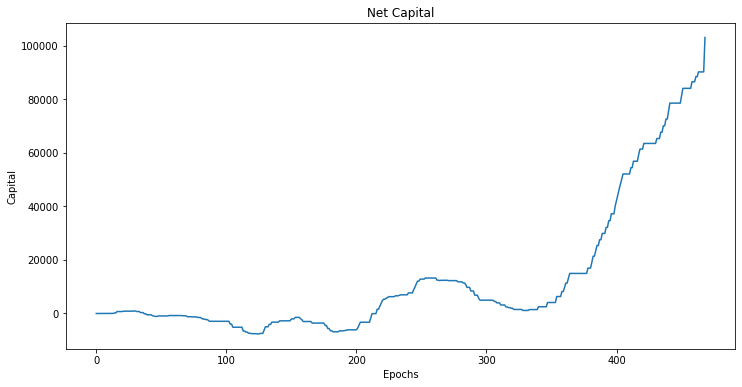

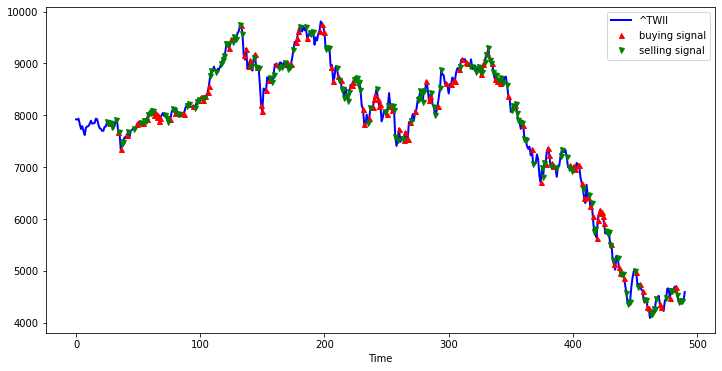

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 54/75

Closed Profit - $ 126.8   Current Profit: - $ 39942.1
########################
TOTAL PROFIT: - $ 39942.1. Time taken for 1 episode: 41.19 secs
########################


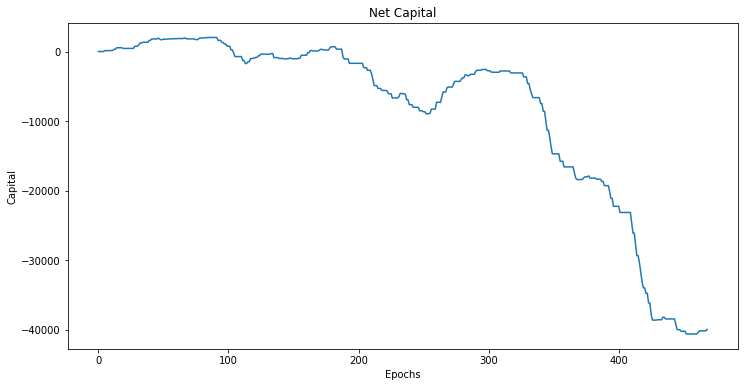

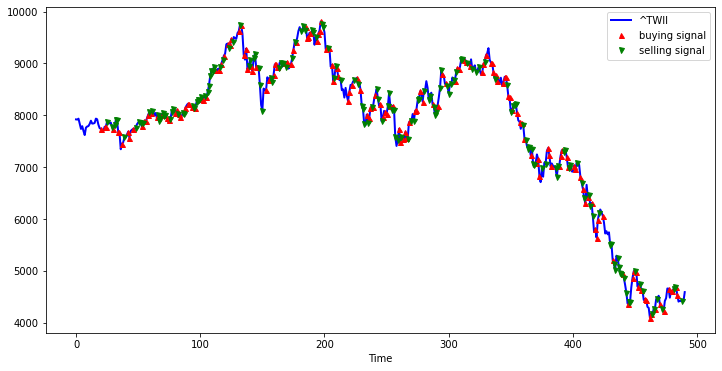

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 55/75

Closed Profit - $ 1915.2   Current Profit: - $ 66765.8
########################
TOTAL PROFIT: - $ 66765.8. Time taken for 1 episode: 42.24 secs
########################


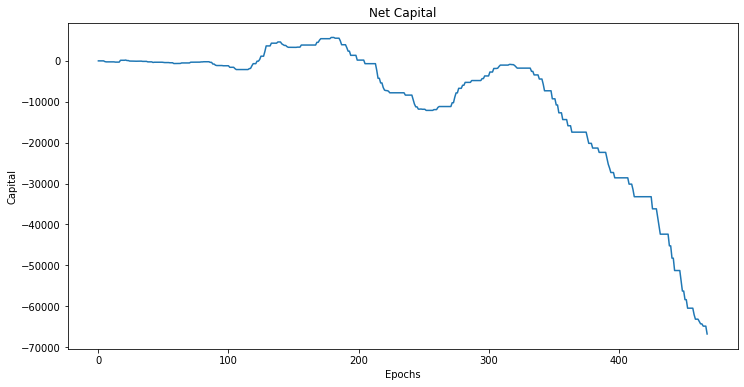

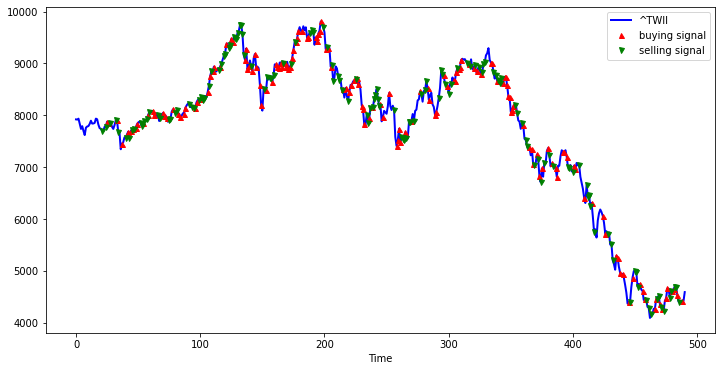

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 56/75

Closed Profit $ 953.9   Current Profit: - $ 32413.3
########################
TOTAL PROFIT: - $ 32413.3. Time taken for 1 episode: 41.51 secs
########################


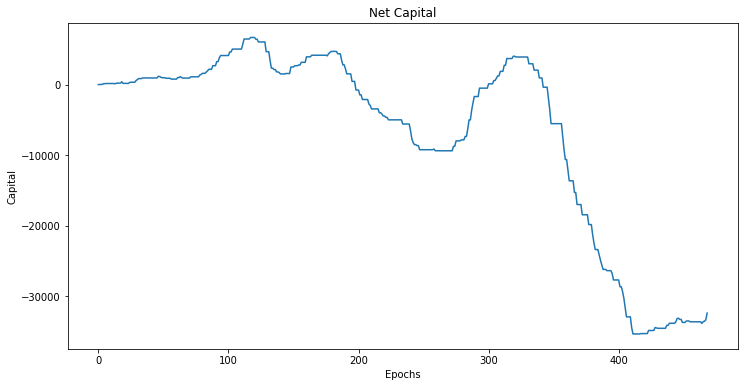

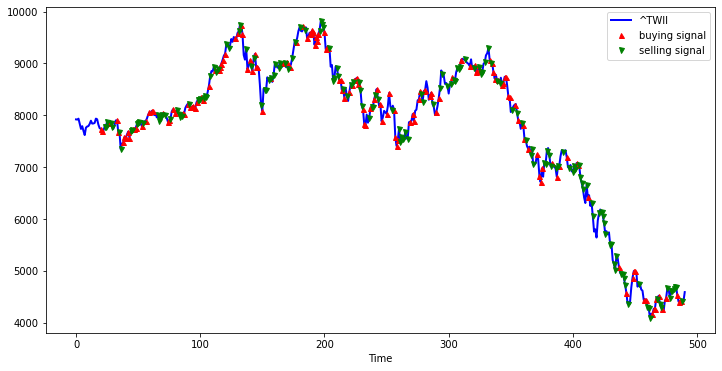

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 57/75

Closed Profit - $ 648.4   Current Profit: - $ 3097.4
########################
TOTAL PROFIT: - $ 3097.4. Time taken for 1 episode: 41.55 secs
########################


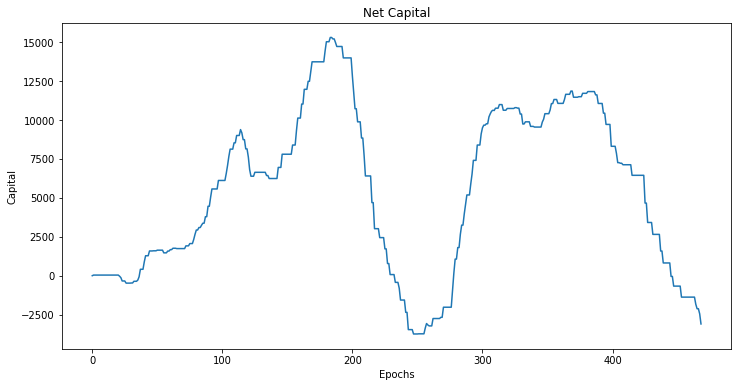

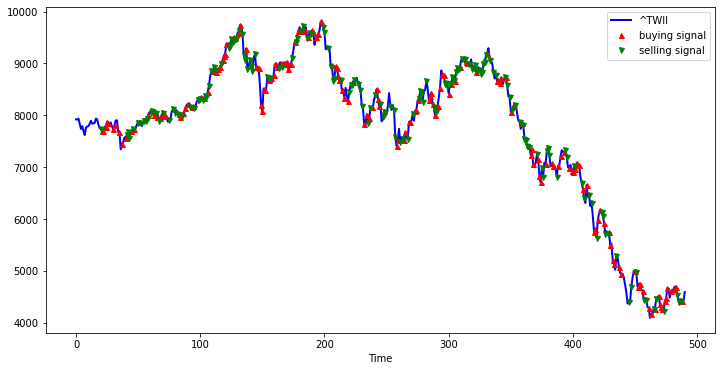

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 58/75

Closed Profit - $ 106.1   Current Profit: $ 45001.0
########################
TOTAL PROFIT: $ 45001.0. Time taken for 1 episode: 42.0 secs
########################


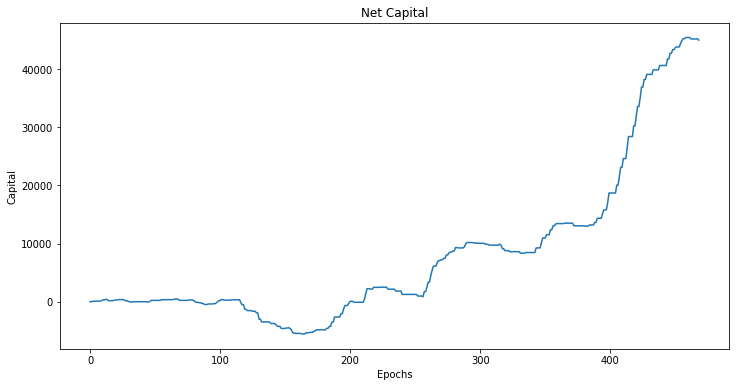

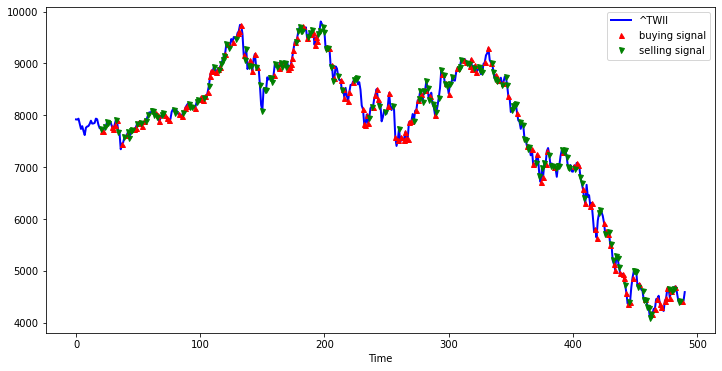

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 59/75

Closed Profit $ 2874.6   Current Profit: $ 84216.5
########################
TOTAL PROFIT: $ 84216.5. Time taken for 1 episode: 41.47 secs
########################


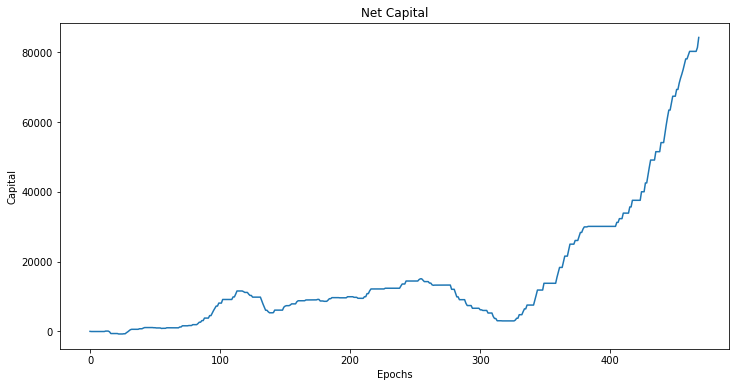

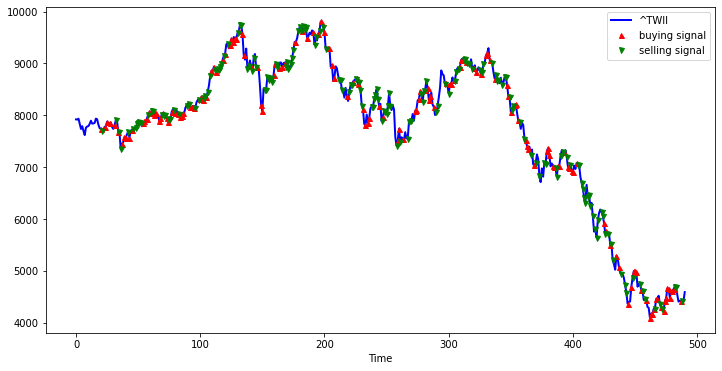

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 60/75

Closed Profit - $ 617.0   Current Profit: - $ 20810.0
########################
TOTAL PROFIT: - $ 20810.0. Time taken for 1 episode: 41.87 secs
########################


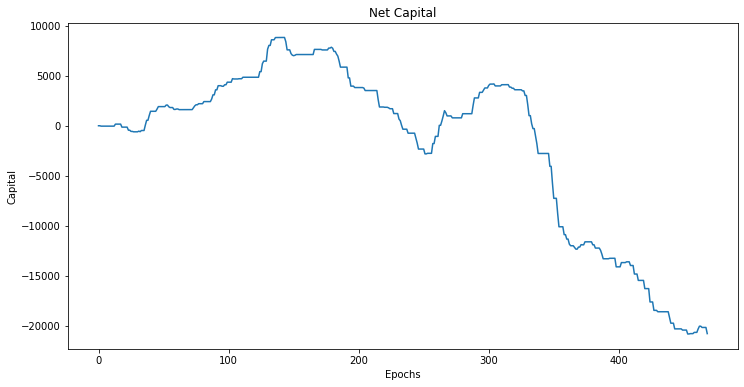

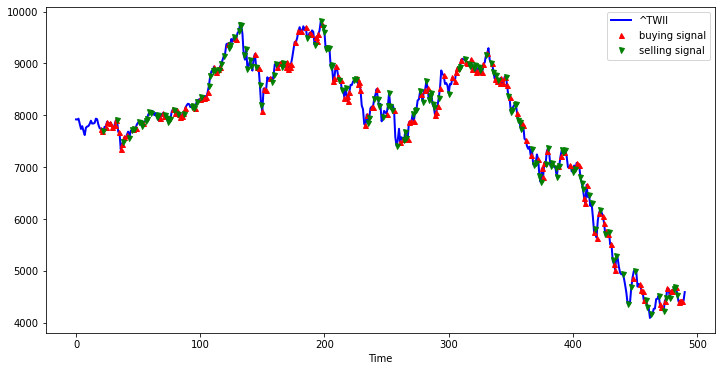

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 61/75

Closed Profit - $ 305.6   Current Profit: $ 59189.2
########################
TOTAL PROFIT: $ 59189.2. Time taken for 1 episode: 41.46 secs
########################


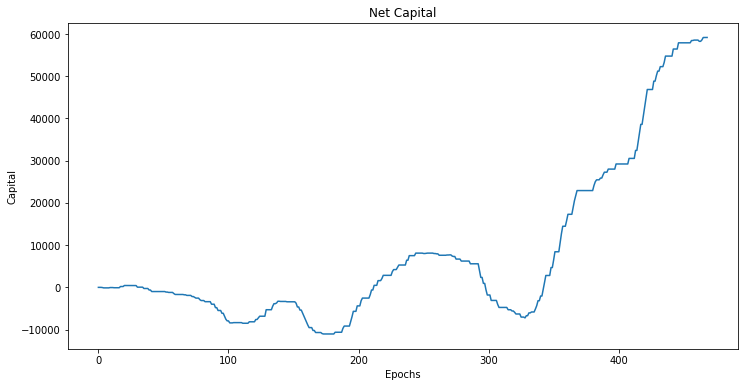

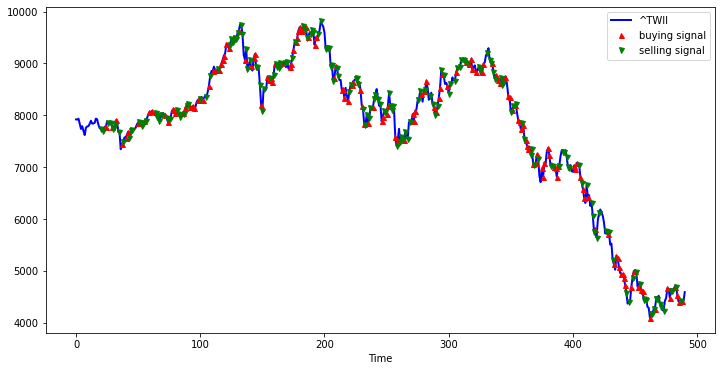

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 62/75

Closed Profit - $ 11262.5   Current Profit: - $ 66845.8
########################
TOTAL PROFIT: - $ 66845.8. Time taken for 1 episode: 41.53 secs
########################


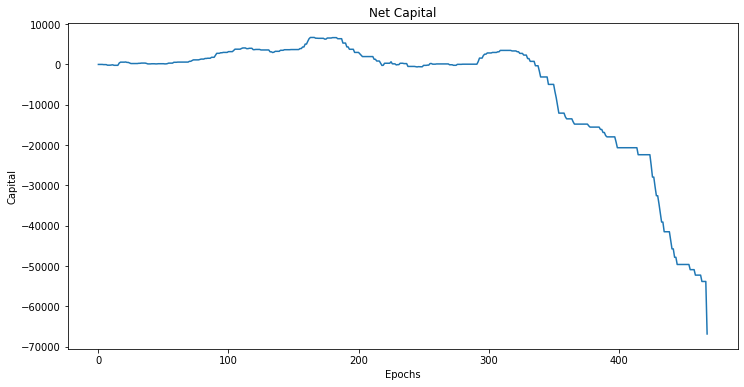

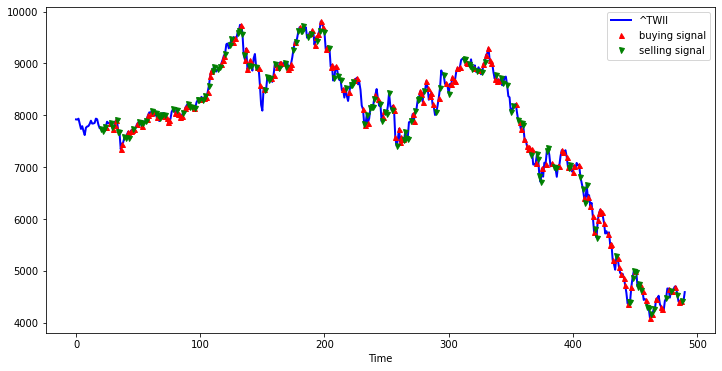

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 63/75

Closed Profit - $ 1185.3   Current Profit: - $ 46508.0
########################
TOTAL PROFIT: - $ 46508.0. Time taken for 1 episode: 41.59 secs
########################


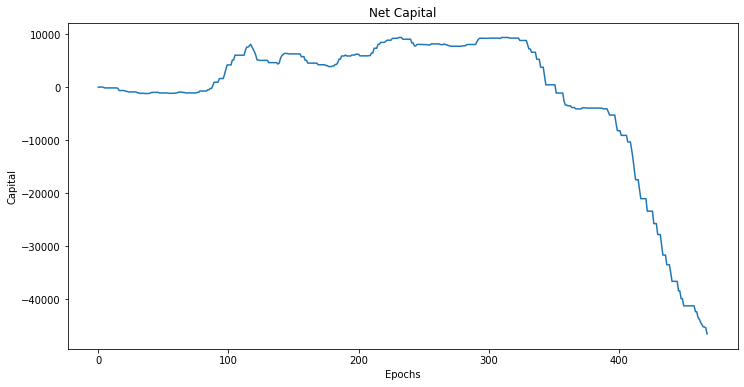

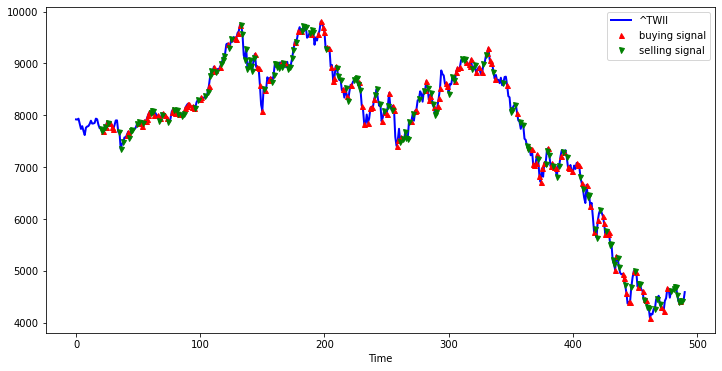

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 64/75

Closed Profit - $ 1078.2   Current Profit: - $ 52097.9
########################
TOTAL PROFIT: - $ 52097.9. Time taken for 1 episode: 42.26 secs
########################


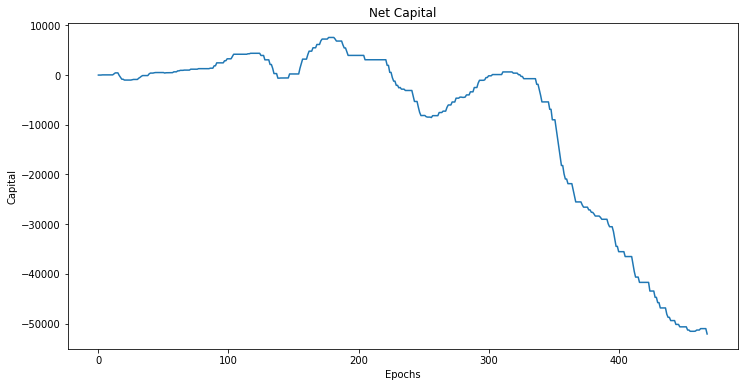

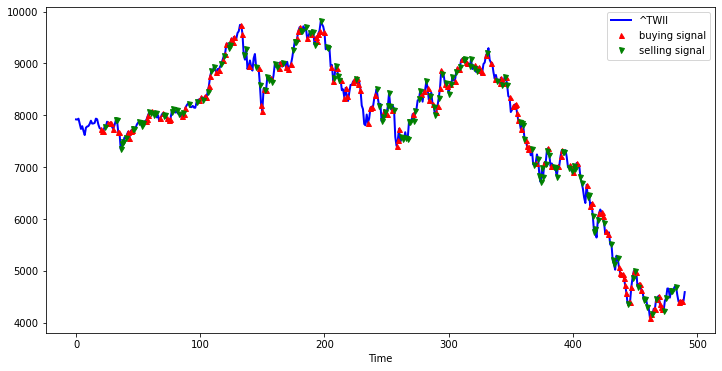

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 65/75

Closed Profit - $ 97.2   Current Profit: - $ 29315.3
########################
TOTAL PROFIT: - $ 29315.3. Time taken for 1 episode: 41.85 secs
########################


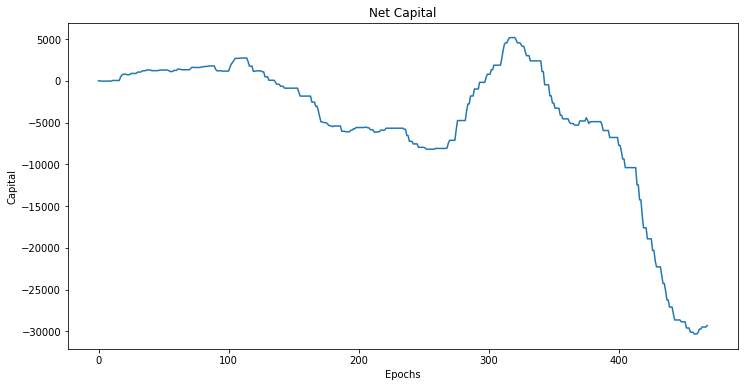

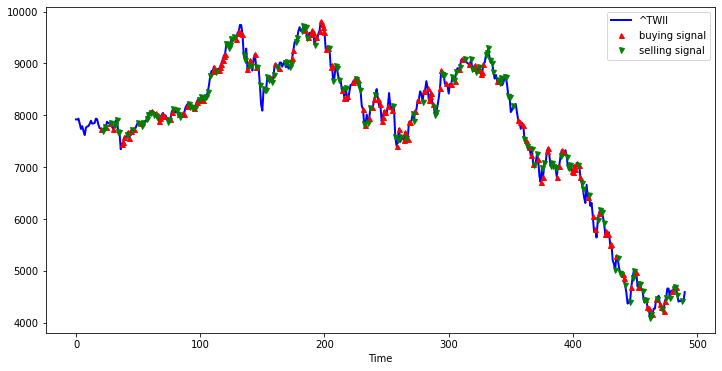

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 66/75

Closed Profit $ 2891.2   Current Profit: $ 61731.0
########################
TOTAL PROFIT: $ 61731.0. Time taken for 1 episode: 41.9 secs
########################


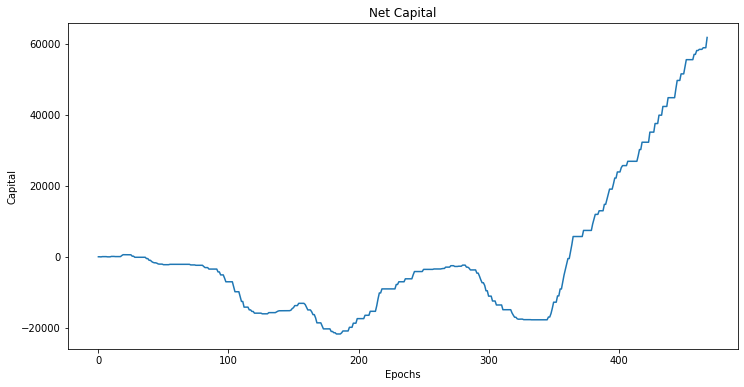

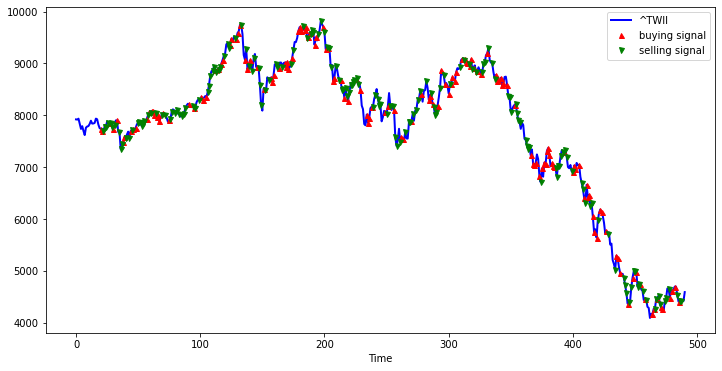

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 67/75

Closed Profit $ 5346.0   Current Profit: $ 52885.6
########################
TOTAL PROFIT: $ 52885.6. Time taken for 1 episode: 41.87 secs
########################


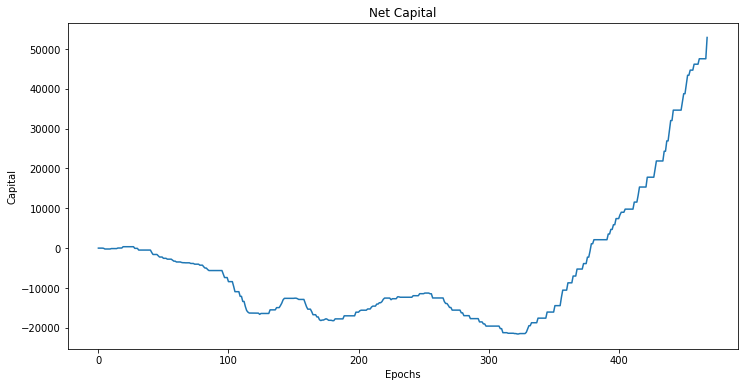

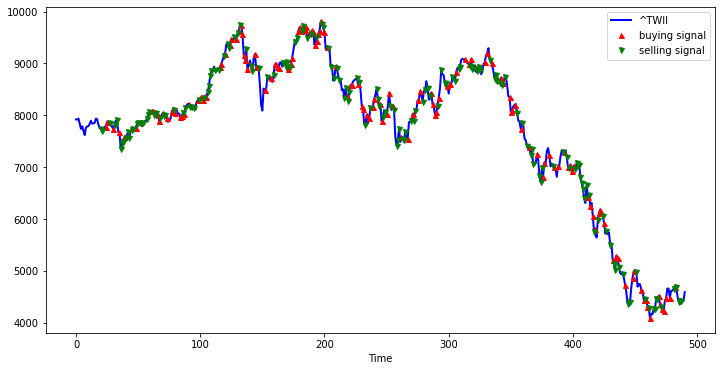

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 68/75

Closed Profit $ 1261.5   Current Profit: $ 59293.3
########################
TOTAL PROFIT: $ 59293.3. Time taken for 1 episode: 43.13 secs
########################


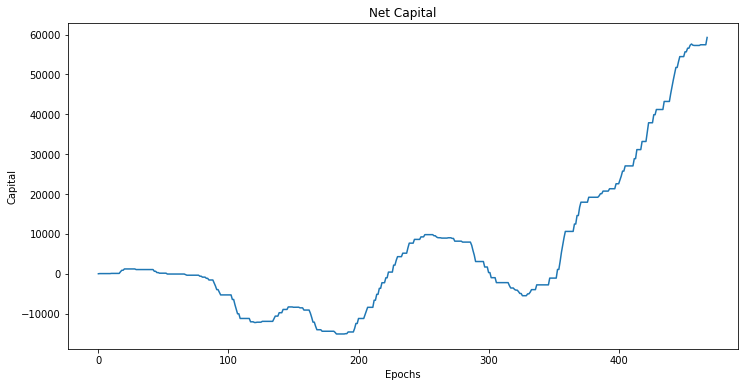

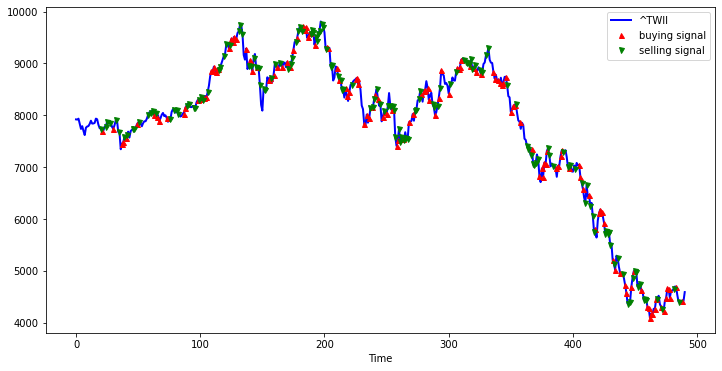

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 69/75

Closed Profit - $ 2270.9   Current Profit: - $ 63412.3
########################
TOTAL PROFIT: - $ 63412.3. Time taken for 1 episode: 42.66 secs
########################


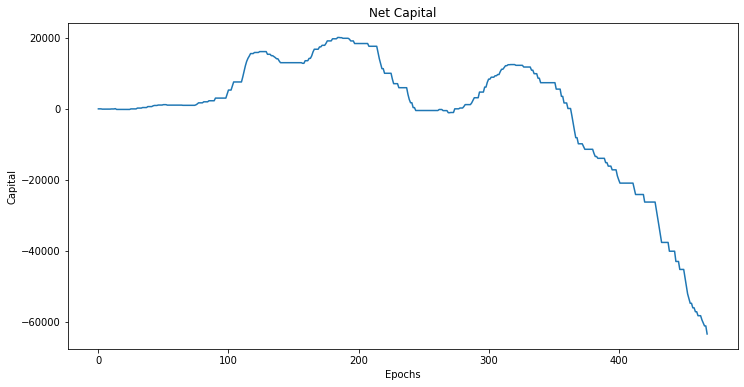

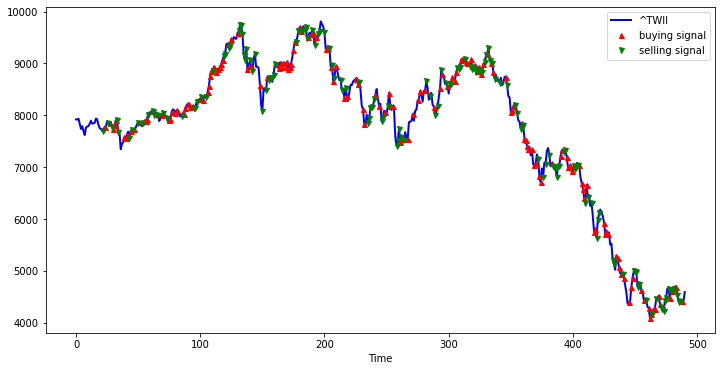

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 70/75

Closed Profit $ 193.0   Current Profit: - $ 51582.8
########################
TOTAL PROFIT: - $ 51582.8. Time taken for 1 episode: 41.95 secs
########################


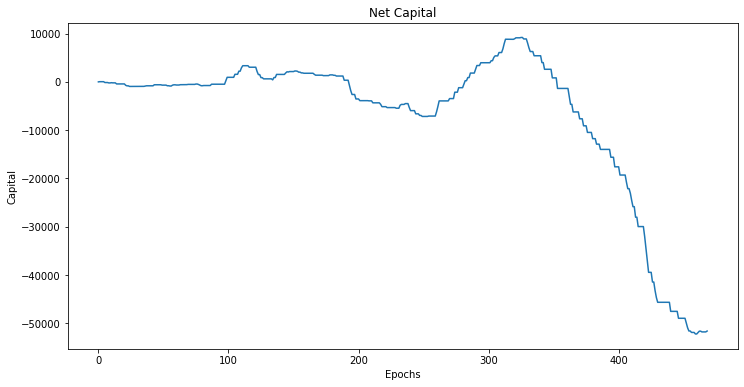

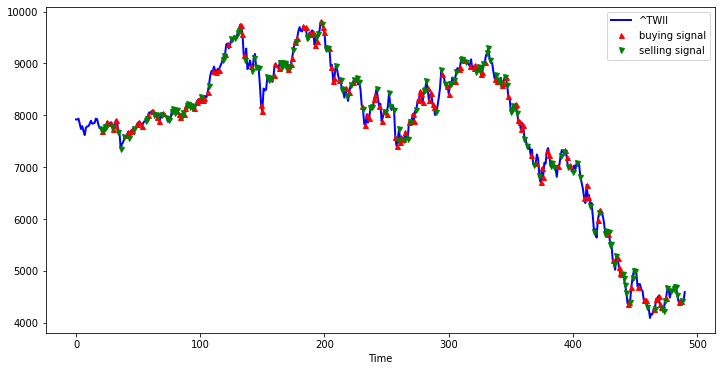

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 71/75

Closed Profit - $ 66.7   Current Profit: - $ 7915.8
########################
TOTAL PROFIT: - $ 7915.8. Time taken for 1 episode: 58.67 secs
########################


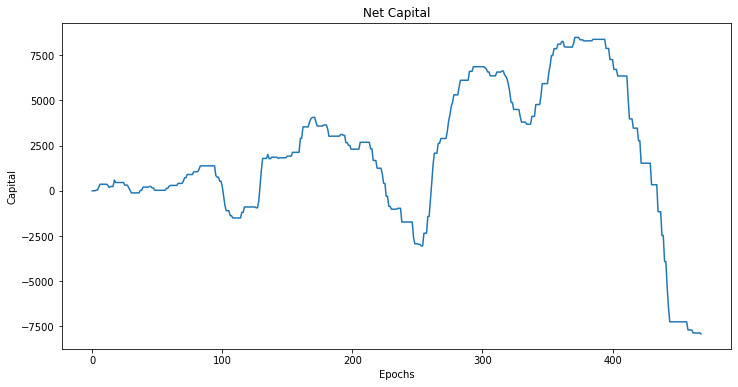

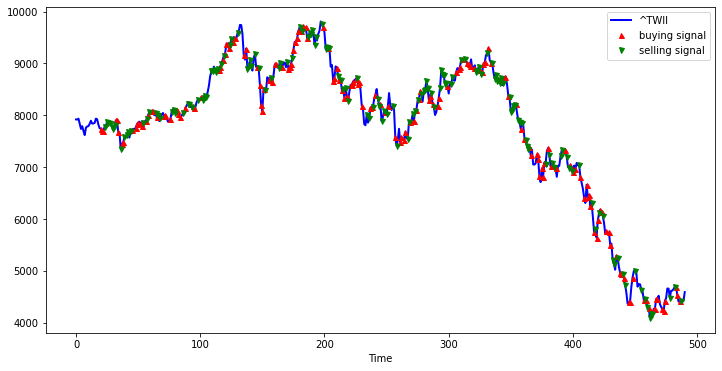

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 72/75

Closed Profit $ 248.2   Current Profit: - $ 17724.8
########################
TOTAL PROFIT: - $ 17724.8. Time taken for 1 episode: 45.06 secs
########################


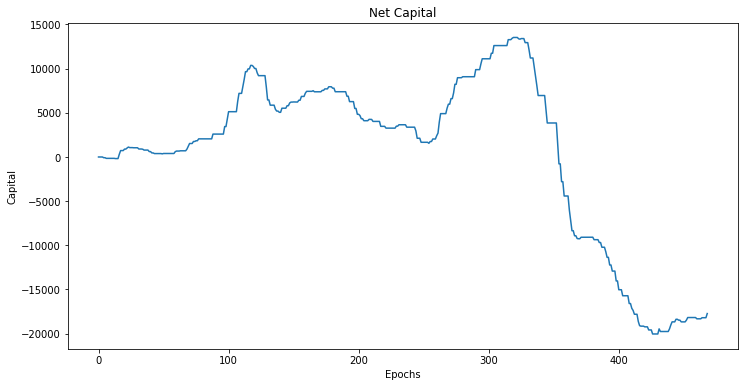

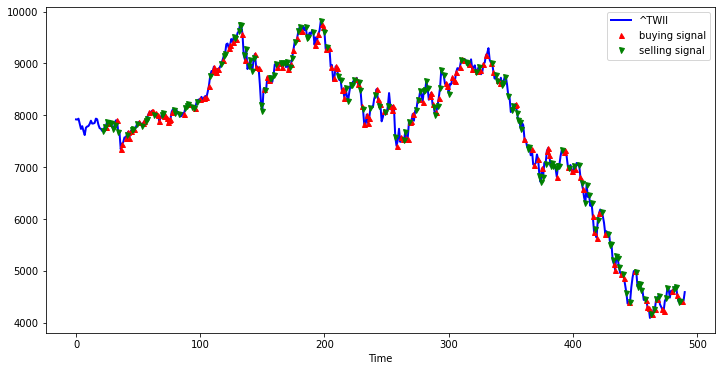

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 73/75

Closed Profit $ 630.8   Current Profit: $ 53298.4
########################
TOTAL PROFIT: $ 53298.4. Time taken for 1 episode: 46.03 secs
########################


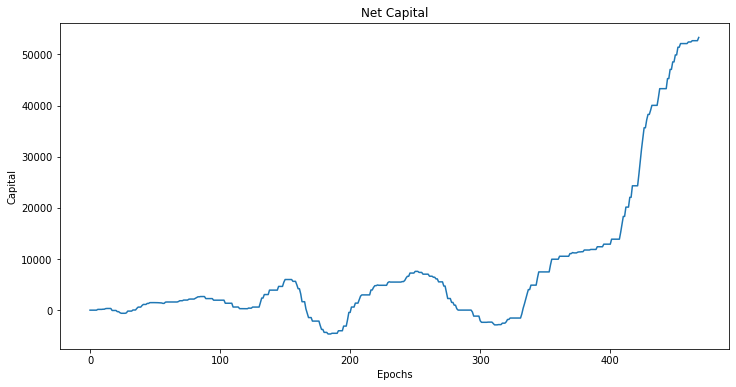

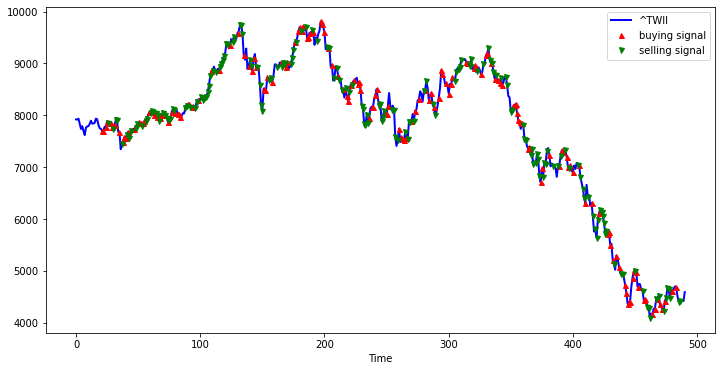

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 74/75

Closed Profit - $ 5861.9   Current Profit: - $ 72183.6
########################
TOTAL PROFIT: - $ 72183.6. Time taken for 1 episode: 55.82 secs
########################


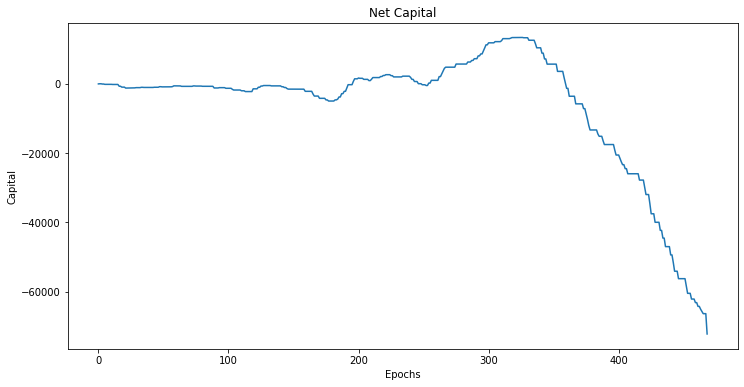

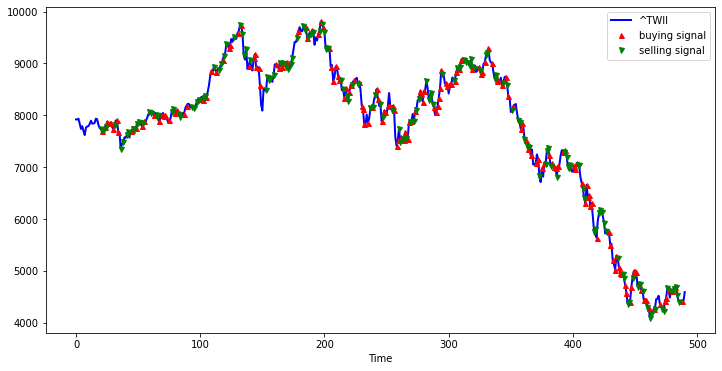

  0%|          | 0/469 [00:00<?, ?it/s]

Episode: 75/75

Closed Profit $ 17170.5   Current Profit: $ 86834.4
########################
TOTAL PROFIT: $ 86834.4. Time taken for 1 episode: 51.52 secs
########################


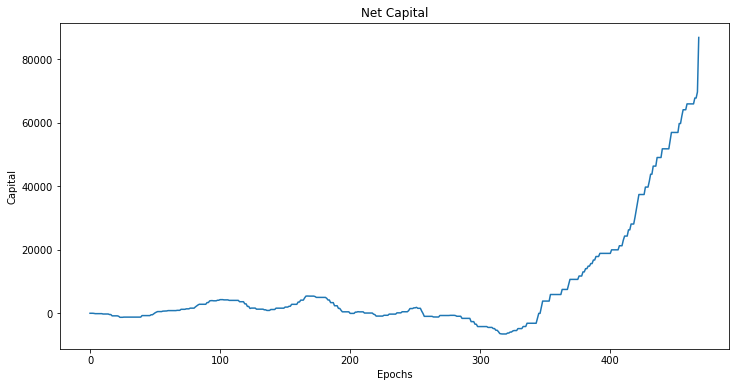

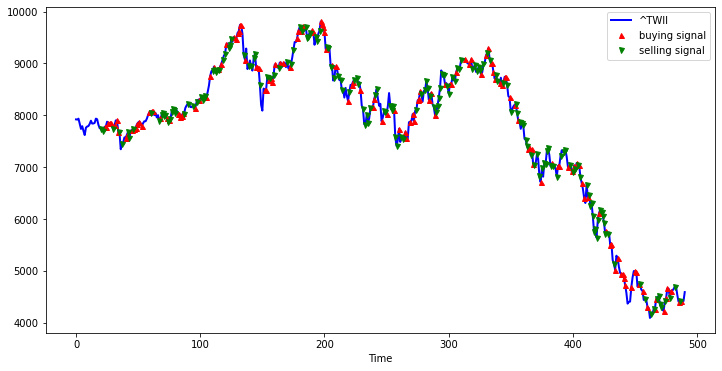

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
trade_training_process = []
trader.performace_calculate(data, y, window_size, episodes, budget, data_samples, batch_size, trade_training_process)

### Profitablility Trend

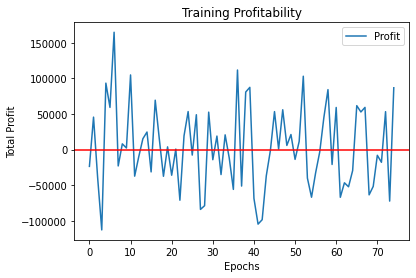

In [ ]:
plt.plot(trade_training_process)
plt.title('Training Profitability')
plt.ylabel('Total Profit')
plt.xlabel('Epochs')
plt.legend(['Profit'])
plt.axhline(y = 0, color = 'red', linestyle = '-')
plt.show()

## Stage 6: Testing the AI Trader

### Loading a testing dataset

In [ ]:
data1 = dataset_loader(stock_name, start_time = end_time)
# y, data = high_frequency_dataset_loader(stock_name, period = '7d', interval = '1m')
y = yf.download(stock_name, start=end_time)['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
data1

Date
2009-01-06    0.006143
2009-01-07    0.013151
2009-01-08   -0.054498
2009-01-09   -0.007313
2009-01-12   -0.010906
                ...   
2022-12-26    0.000945
2022-12-27    0.003027
2022-12-28   -0.010900
2022-12-29   -0.006234
2022-12-30    0.003733
Name: Close, Length: 3430, dtype: float64

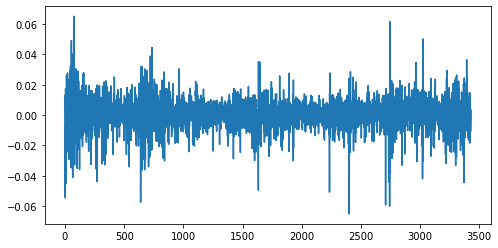

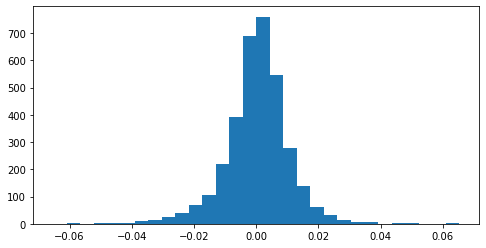

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(data1.values)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(data1, bins = 30)
plt.show()

### Model implementation

In [ ]:
state_creator(data1, window_size+1, window_size + 1).reshape(1, -1)

array([[ 0.01315127, -0.0544977 , -0.00731313, -0.01090606,  0.01746265,
        -0.00240554, -0.04540358,  0.00759247,  0.00299516, -0.02884265,
         0.00126266,  0.00282319,  0.02614138,  0.00391661, -0.00610525,
         0.02445082,  0.0052064 ,  0.00698625,  0.01095371, -0.02422719]])

In [ ]:
long_time = []
short_time = []
def model_trading(model, data, y, budget):
  long_inventory = []
  short_inventory = []
  net_capital = []
  state = state_creator(data, window_size, window_size + 1).reshape(1, -1)
  total_profit = 0
  data_samples = len(data)
  done = False
  emotion = np.array(0).reshape(-1, 1)
  long_poisition = np.array(len(long_inventory)).reshape(-1, 1)
  short_poisition = np.array(len(short_inventory)).reshape(-1, 1)
  
  for t in tqdm(range(window_size, len(data))):
    if len(long_inventory) > 0:
      emotion = np.array(sum(-np.array(long_inventory) + y[t])).reshape(-1, 1)
    
    if len(short_inventory) > 0:
      emotion = np.array(sum(-np.array(short_inventory) + y[t])).reshape(-1, 1)

    p, _ = model.predict([state, emotion, long_poisition, short_poisition], verbose = 0)
    action = np.random.choice(p.shape[1], size = 1, replace = False, p = p[0])

    if action == 0 and len(long_inventory) < budget and len(short_inventory) == 0:
      long_time.append(t)
      long_inventory.append(y[t])
      # print("\nAt {}/{}, AI Trader bought: ".format(t+1, data_samples), stocks_price_format(y[t]), ', Long Position Inventory: ', len(long_inventory))
    elif action == 0 and len(long_inventory) == 0 and len(short_inventory) > 0:
        long_time.append(t)
        sell_price = short_inventory.pop(0)
        p = sell_price - y[t]
        reward = p
        total_profit += p
        print("\nAt {}/{}, AI Trader closed position: ".format(t+1, data_samples), stocks_price_format(y[t]), " Profit: " + stocks_price_format(p), " Current Profit: " + stocks_price_format(total_profit))

    elif action == 1 and len(long_inventory) > 0:
      short_time.append(t)
      buy_price = long_inventory.pop(0)
      p = y[t] - buy_price
      total_profit += p
      # print("\nAt {}/{}, AI Trader sold: ".format(t+1, data_samples), stocks_price_format(y[t]), " Profit: " + stocks_price_format(p), " Current Profit: " + stocks_price_format(total_profit))
      
    elif action == 1 and len(short_inventory) < budget and len(long_inventory) == 0:
      short_time.append(t)
      short_inventory.append(y[t])
      holding_times = 0
      # print("\nAt {}/{}, AI Trader shorted: ".format(t+1, data_samples), stocks_price_format(y[t]), ', Short Position Inventory: ', len(short_inventory))

    else:
      # print("\nAt {}/{}, AI Trader held. ".format(t+1, data_samples), " Current Profit: " + stocks_price_format(total_profit))
    if t == data_samples - 1:
      done = True
      final_p = 0
      if len(long_inventory) > 0:
        for i in long_inventory:
          final_p += y[t] - i
      elif len(short_inventory) > 0:
        for i in short_inventory:
          final_p += i - y[t]
      total_profit += final_p
      # print("\nClosed Profit {} ".format(final_p), " Current Profit: " + stocks_price_format(total_profit))

    if done:
      print("########################")
      print("TOTAL PROFIT: {}".format(total_profit))
      print("########################")
    try:
      net_capital.append(total_profit)
      next_state = state_creator(data, t + 1, window_size + 1).reshape(1, -1)
      state = next_state
    except IndexError:
      continue
  plt.plot(net_capital)
  plt.title('Net Capital')
  plt.ylabel('Capital')
  plt.xlabel('Epochs')
  plt.show()

### Profitability visualization

Streaming output truncated to the last 5000 lines.
At 933/3430, AI Trader held.   Current Profit: $ 41060.9

At 934/3430, AI Trader bought:  $ 7592.0 , Long Position Inventory:  7

At 935/3430, AI Trader sold:  $ 7451.7  Profit: - $ 127.1  Current Profit: $ 40933.8

At 936/3430, AI Trader held.   Current Profit: $ 40933.8

At 937/3430, AI Trader bought:  $ 7418.9 , Long Position Inventory:  7

At 938/3430, AI Trader bought:  $ 7471.0 , Long Position Inventory:  8

At 939/3430, AI Trader held.   Current Profit: $ 40933.8

At 940/3430, AI Trader bought:  $ 7465.4 , Long Position Inventory:  9

At 941/3430, AI Trader sold:  $ 7408.8  Profit: - $ 329.3  Current Profit: $ 40604.5

At 942/3430, AI Trader held.   Current Profit: $ 40604.5

At 943/3430, AI Trader held.   Current Profit: $ 40604.5

At 944/3430, AI Trader sold:  $ 7314.9  Profit: - $ 467.0  Current Profit: $ 40137.5

At 945/3430, AI Trader sold:  $ 7262.1  Profit: - $ 472.0  Current Profit: $ 39665.4

At 946/3430, AI Trader sold

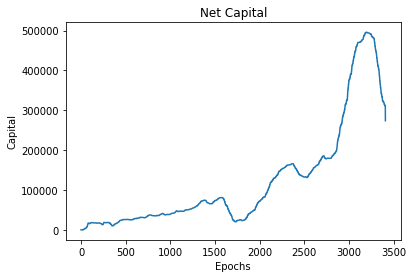

In [ ]:
model_trading(trader.model, data1, y, budget = len(data1))

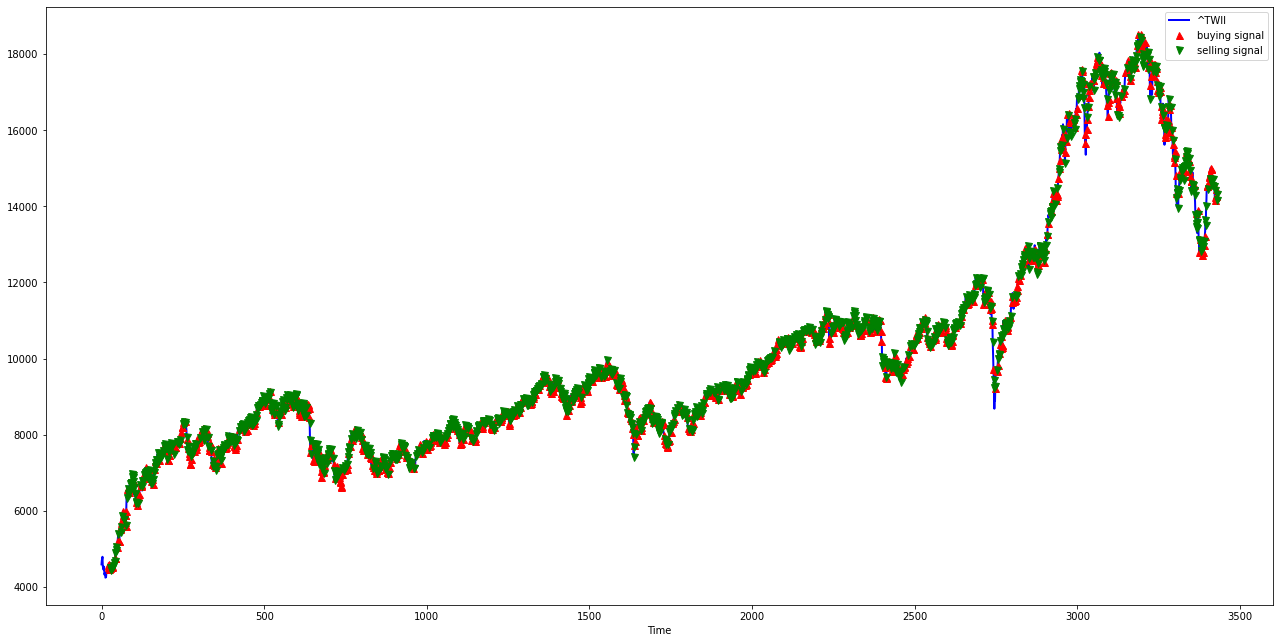

In [ ]:
plt.figure(figsize=(22,11))
plt.plot(y.values, color = 'blue', label = stock_name, lw=2.)  
plt.plot(y.values, '^', markersize=7, color='red', label = 'buying signal', markevery = long_time)
plt.plot(y.values, 'v', markersize=7, color='green', label = 'selling signal', markevery = short_time)
plt.xlabel('Time')
plt.legend()
plt.show()